# QUICK NOTES FROM REWATCHING LECTURE:
data matrix should NOT contain averages of each person! Just the individual images!

* note: matlab [V, D] = eigs(D'*D) is equivalent to numyp's [D, V] = np.linalg.eig(np.matmul(np.transpose(D), D))

so later, plotting V(:, 1) reshaped into the original image is plotting first column of the eigenvector matrix... for U, S, V = svd(A), should be the same as plotting U[:, 1]? (YES! as in `np.reshape(Uhat[:, 1], (192, 168))`) --> so plot the eigenfaces/eigenvectors/columns of U in figure 3 in the lecture

* **Fig 1**: all the faces
* **Fig 2**: average faces of each person
* **Fig 3**: eigenfaces/eigenvectors (first 5) + semilog plot of the singular values (for him, it was the eigenvalues) - the first one is the "dominant eigenface correlated amongst these pictures"; and the singular values ("potting the diagonal to show how big they are")

--> 1st one is the average face of all pics... tells you average face dominates!

--> want to project onto OTHERS to see how you're different

--> face recognition: what is (this person) outside of the average face? How are (any of these pictures) different form the mean?
* **Fig 4**: make vector by reshaping the average person for some person; then multiply that by V (U for you) (eigenvector matrix); then make a bar chart of proj(1:) --> see outside of the average!)

--> this is the bar chart figure

--> Ave * U = (1, 32256) * (32256, 38): so you get a (1, 38) vector!

--> SO: `proj0 = np.matmul(np.reshape(cropped_pics[0], (1, 32256)), Uhat)` and `plt.bar(np.arange(1, 38), proj0.flatten()[1:])`

--> this is the histogram of the average subject xxx face projected onto the eigenvector space; WHAT'S IMPORTANT is that every person has a different projection of the faces generated from all 20 people! Like a key/encoding for each person onto those eigenvectors! They're unique! --> could use these for classification tasks... if you get a spectrum from projection that looks like one subject vs. another

* **Fig 5**: testing/face recognition: top left = NEW picture of one of the subjects (just display the pic), project onto the eigenvector space & show that bar chart (fig. 4), then reconstruct their face onto that eigenspace (so plot U x (Uxproj'), then bars of her average face projecting onto the original images you had of that person (so distance of new picture to the original average subjects...? Not 100% sure what that is)

--> OR below, new PERSON, their bar chart projection, their reconstruction, and their scores compared to the faces you know (see below - code for the reconstruction!)

--> ^I think I want to do this part with the uncropped? Like see whose face from the cropped looks most like that person??????


# Draft code for homework 2
...because it's easier to mess around in a Jupyter notebook than in a python script!

Note: all images in this script are assumed to be in grayscale; this is true for the Yale images used in this assignment.

In [1]:
import cv2 
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from PIL import Image


Note that the data for the Yale faces datasets can be found on the course website in the "Homework + Data + Text" section: https://faculty.washington.edu/kutz/am584/am584.html. 
        

In [2]:
main_dir = '/Users/jmnugent/Documents/__Year_3_2020-2021/AMATH_584-Numerical_Linear_Algebra/Homework/python/'

crop_dir = main_dir + 'CroppedYale/'
uncrop_dir = main_dir + 'yalefaces_uncropped/yalefaces/'
save_dir = main_dir + 'amath584/hw2_SVD_facial_recognition/'


## Read in the data:
##### Get the data matrices for all images within each subject's subfolder and average them

### Cropped:

In [3]:
# get a list of paths to each subfolder in CroppedYale
paths = [crop_dir + dirname for dirname in os.listdir(crop_dir)
         if os.path.isdir(os.path.join(crop_dir, dirname))]

# initialize list to hold the averaged data matrices for each image
n_img = len(paths)
cropped_pics = [[]]*n_img
cropped_avgs = [[]]*n_img

for i in range(n_img):
    # get the list of file names within the subfolder for that image
    subfolder = paths[i] + '/'
    imagenames = [subfolder + f for f in os.listdir(subfolder)
                  if os.path.isfile(os.path.join(subfolder, f))]
    
    # make one list containing the data matrices for each (grayscale) image 
    cropped_pics[i] = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY) for x in imagenames]

    # averaged the data matrix for this image and add to the list
    cropped_avgs[i] = np.mean(cropped_pics[i], axis=0)
    

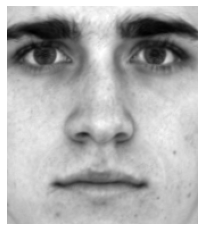

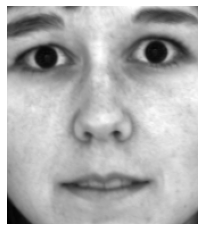

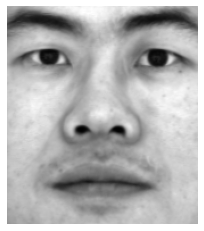

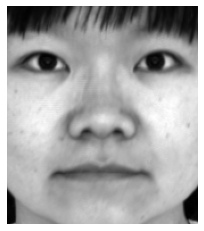

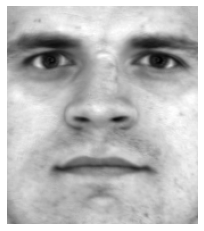

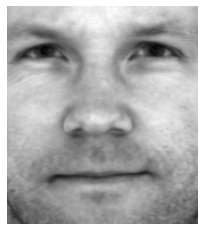

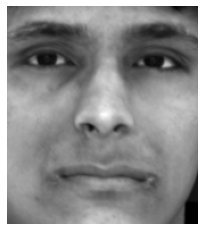

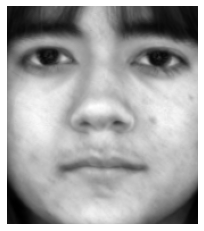

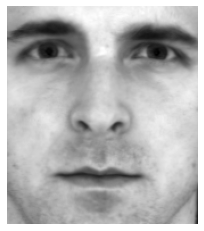

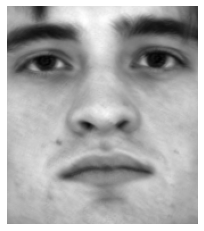

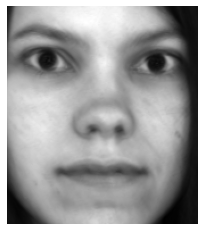

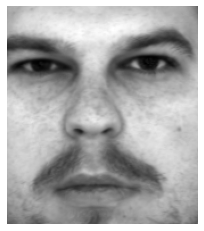

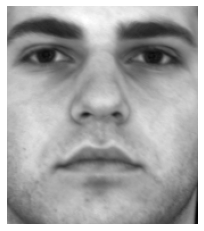

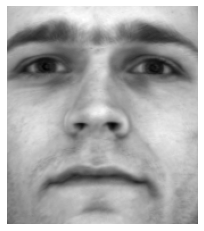

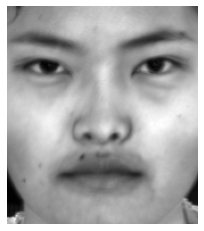

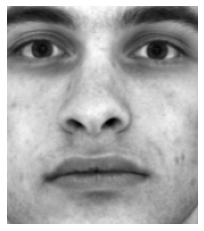

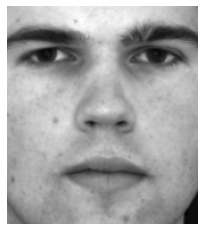

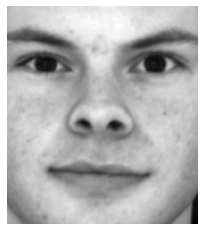

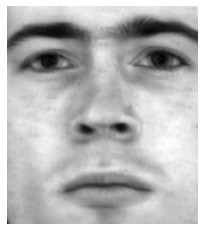

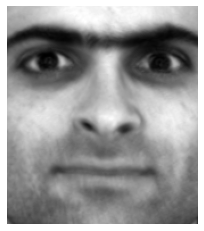

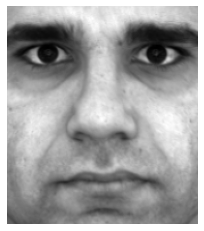

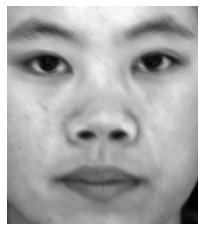

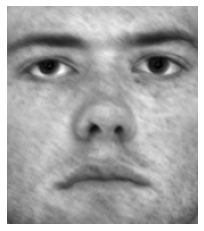

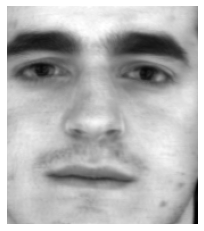

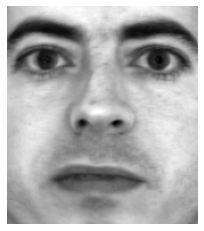

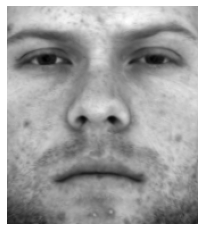

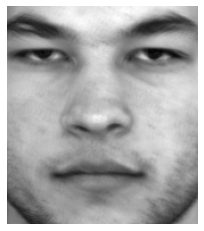

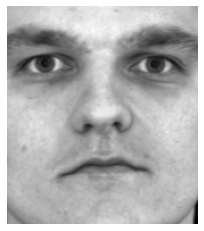

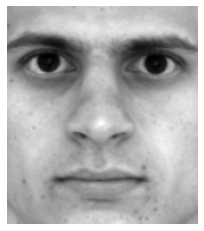

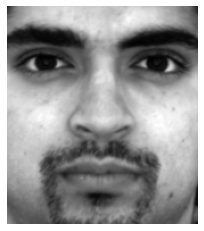

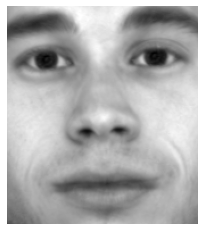

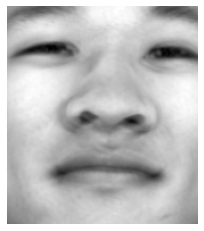

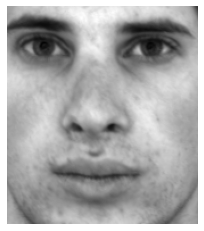

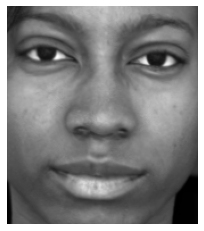

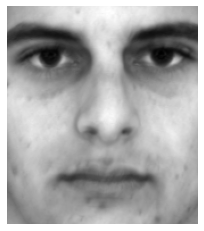

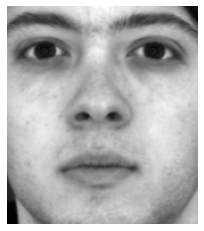

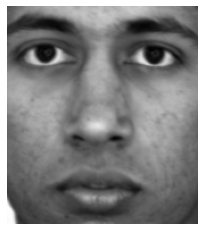

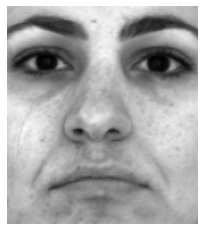

In [4]:
# test it! - looking at the average faces for all 38 subjects

for i in range(len(cropped_avgs)):
    plt.imshow(cropped_avgs[i], cmap='gray')
    plt.axis('off')
    plt.show()


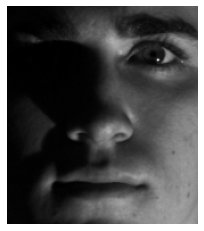

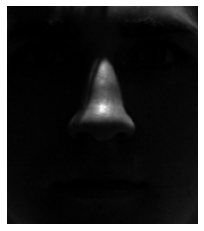

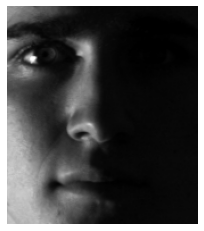

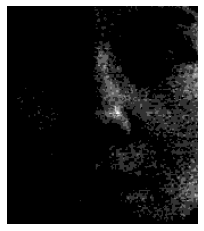

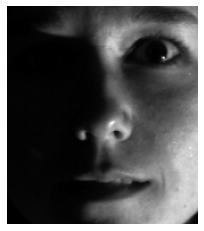

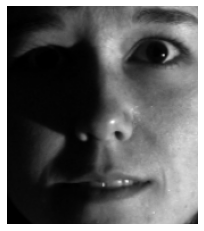

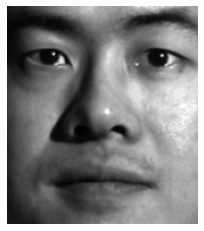

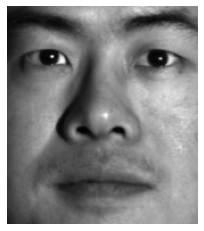

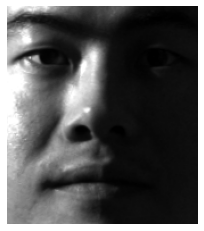

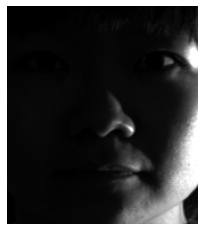

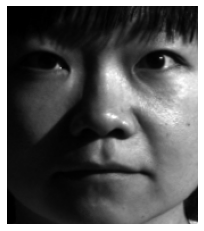

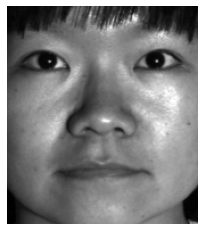

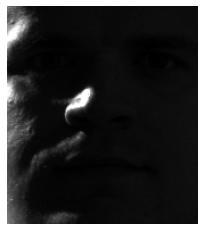

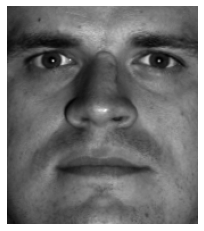

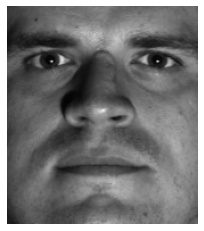

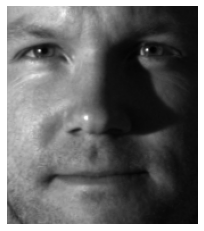

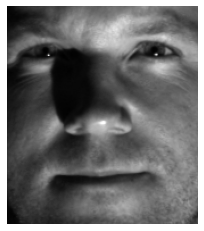

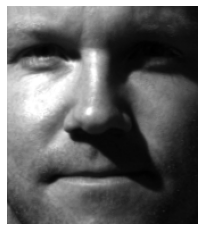

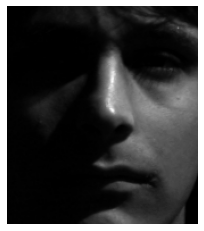

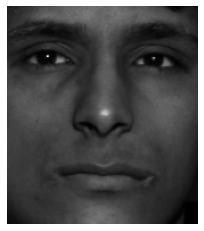

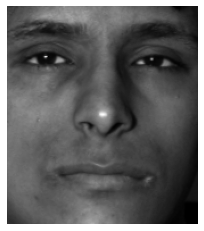

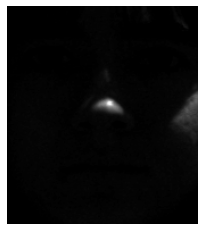

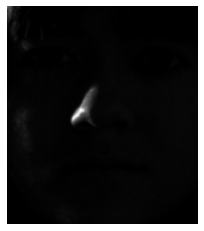

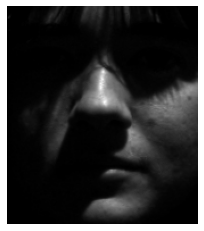

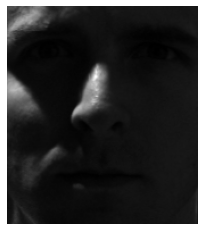

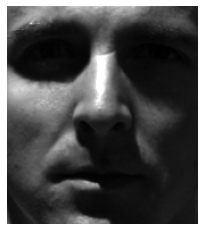

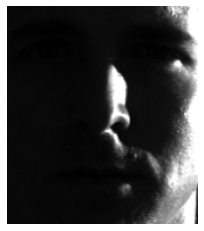

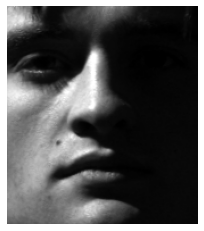

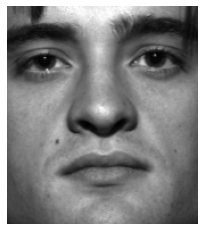

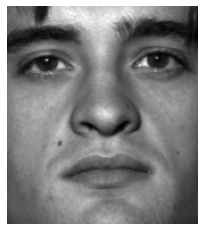

In [5]:
# test it! - looking at the first 3 pictures for the first 10 subjects

for i in range(0, 10):
    for j in range(0, 3):
        plt.imshow(cropped_pics[i][j], cmap='gray')
        plt.axis('off')
        plt.show()
        

### Uncropped:
Note that the uncropped images are gif files, so we cannot read them in with cv2 as before; instead, we use pillow (PIL). 

In [6]:
# get a list of paths to each subfolder in yalefaces_uncropped
unpaths = sorted([uncrop_dir + name for name in os.listdir(uncrop_dir)])

# check that each subject has 11 images in the dataset
if len(unpaths) % 11 == 0:
    n_sub = int(len(unpaths) / 11)
else:
    raise Exception('Invalid number of images! Each subject should have exactly 11 images.')

# initialize list to hold the averaged data matrices for each subject
uncropped_pics = [[]]*n_sub
uncropped_avgs = [[]]*n_sub

for i in range(n_sub):
    # make one list containing the data matrices of the 11 images for that subject
    uncropped_pics[i] = [np.array(Image.open(x).convert('L')) for x in unpaths[i*11:(i+1)*11]]

    # averaged the data matrix for this image and add to the list
    uncropped_avgs[i] = np.mean(uncropped_pics[i], axis=0)


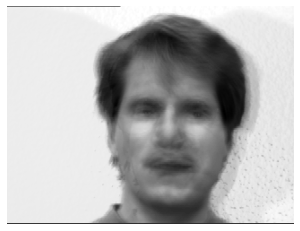

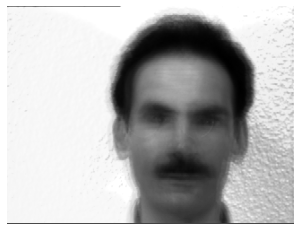

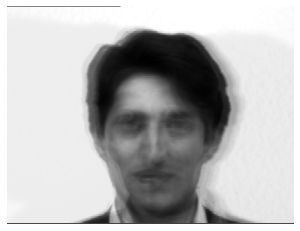

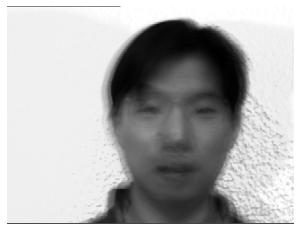

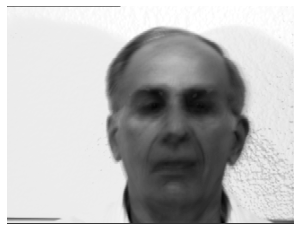

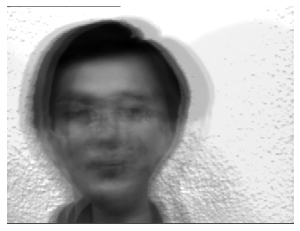

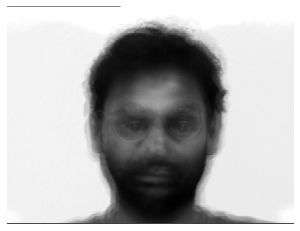

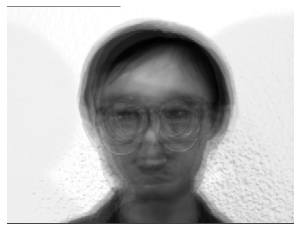

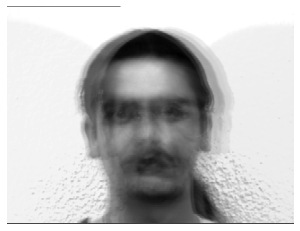

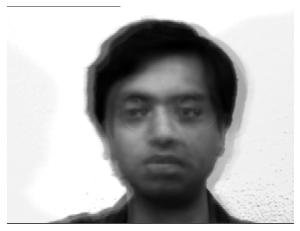

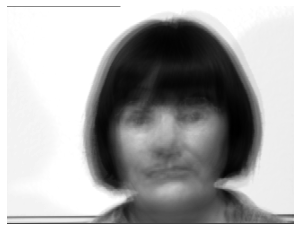

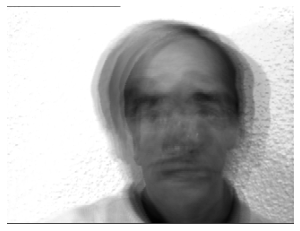

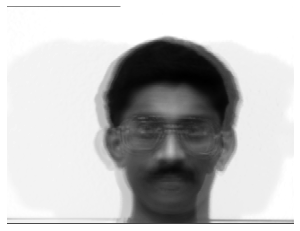

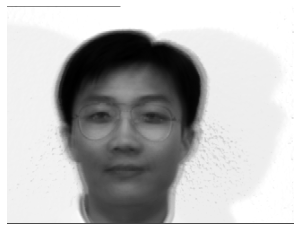

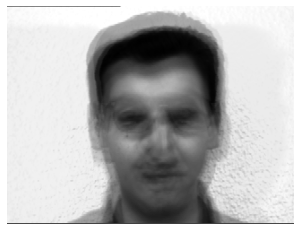

In [7]:
# test it! - looking at the average faces of all 16 subjects

for i in range(len(uncropped_avgs)):
    plt.imshow(uncropped_avgs[i], cmap='gray')
    plt.axis('off')
    plt.show()


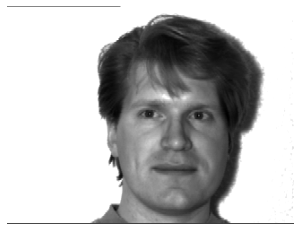

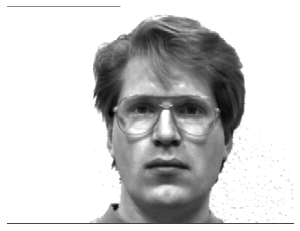

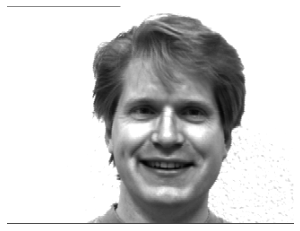

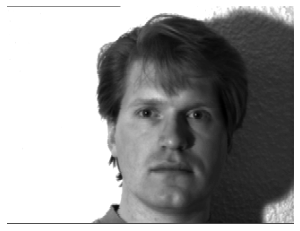

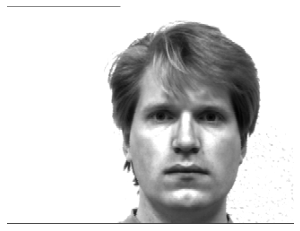

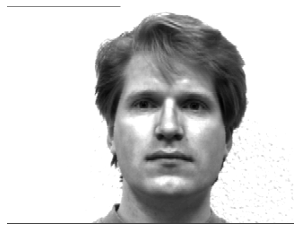

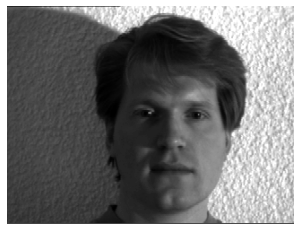

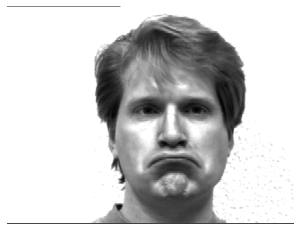

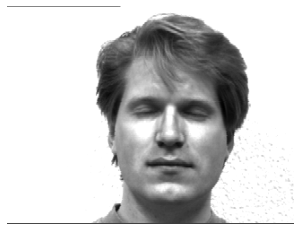

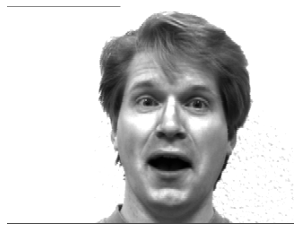

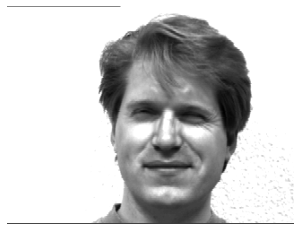

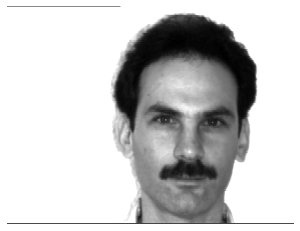

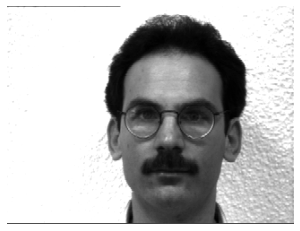

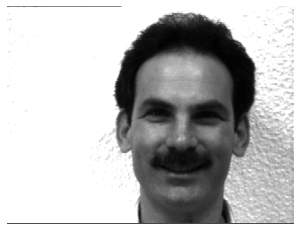

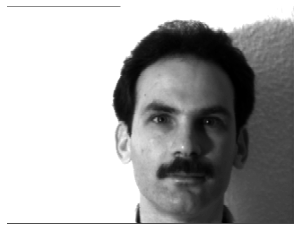

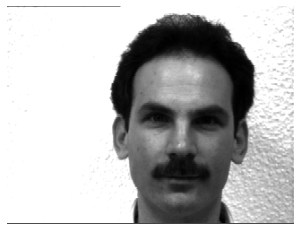

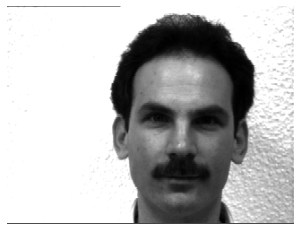

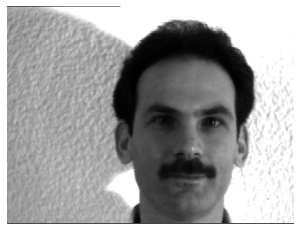

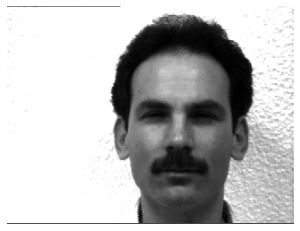

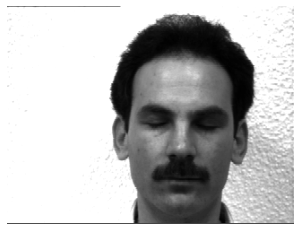

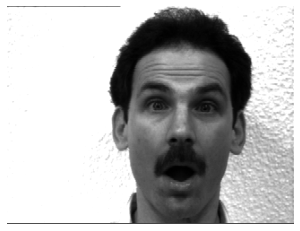

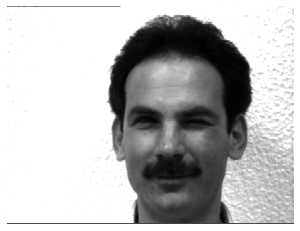

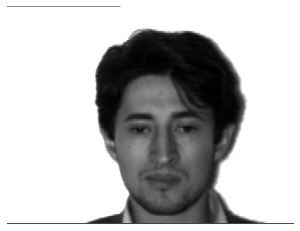

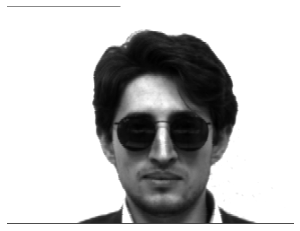

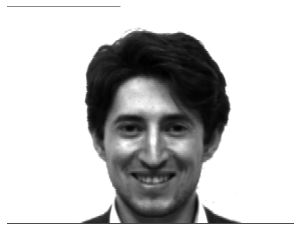

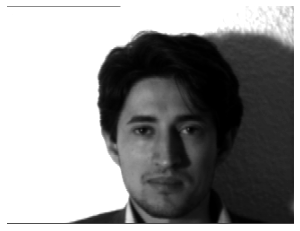

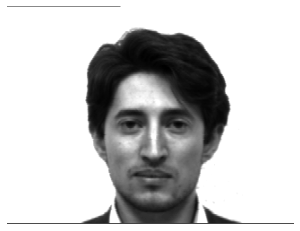

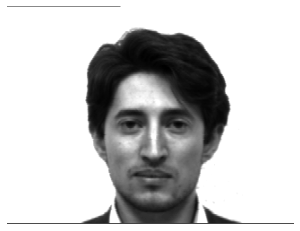

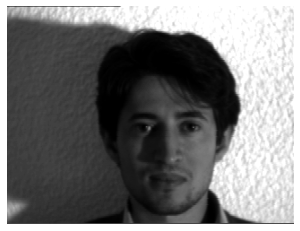

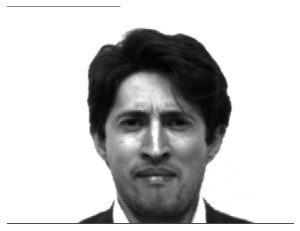

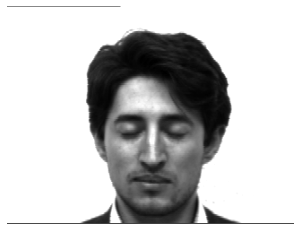

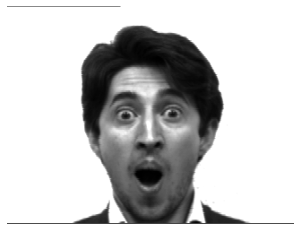

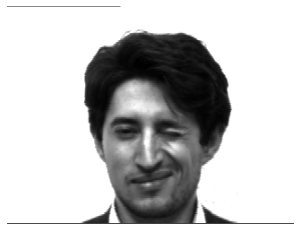

In [8]:
# test it! - looking at all pictures for the first 3 subjects

for i in range(0, 3):
    for j in range(len(uncropped_pics[i])):
        plt.imshow(uncropped_pics[i][j], cmap='gray')
        plt.axis('off')
        plt.show()


## Split the data into training and testing datasets
We want to use 70% of the people for the training data!

Or 70% of pics for all people??

### Cropped:

In [9]:
# n_train_c = int(np.round(len(cropped_avgs)*0.7))

# crop_train = cropped_pics[:n_train_c]
# crop_test = cropped_pics[n_train_c:]

# crop_train_avgs = cropped_avgs[:n_train_c]
# crop_test_avgs = cropped_avgs[n_train_c:]

n_train_c = int(np.round(len(cropped_pics[0])*0.7))

crop_train = [x[:n_train_c] for x in cropped_pics]
crop_test = [x[n_train_c:] for x in cropped_pics]

crop_train_avgs = [np.mean(x, axis=0) for x in crop_train]
crop_test_avgs = [np.mean(x, axis=0) for x in crop_test]


### Uncropped:

In [10]:
# n_train_uc = int(np.round(len(uncropped_avgs)*0.7))

# uncrop_train = uncropped_pics[:n_train_uc]
# uncrop_test = uncropped_pics[n_train_uc:]

# uncrop_train_avgs = uncropped_avgs[:n_train_uc]
# uncrop_test_avgs = uncropped_avgs[n_train_uc:]

n_train_uc = int(np.round(len(uncropped_pics[0])*0.7))

uncrop_train = [x[:n_train_uc] for x in uncropped_pics]
uncrop_test = [x[n_train_uc:] for x in uncropped_pics]

uncrop_train_avgs = [np.mean(x, axis=0) for x in uncrop_train]
uncrop_test_avgs = [np.mean(x, axis=0) for x in uncrop_test]


## 1. Do an SVD analysis of the images
(where each image is reshaped into a column vector and each column is a new image).

### Cropped:

In [11]:
%%time

# stack so each image is one column in the data matrix
A = np.transpose(np.asarray([x.flatten() for x in crop_train[i] for i in range(len(crop_train))]))

# perform (economy) SVD
[U, S, VT] = np.linalg.svd(A, full_matrices=False)


CPU times: user 29.4 s, sys: 1.41 s, total: 30.8 s
Wall time: 18.8 s


In [12]:
# check that the dimensions are correct

print(A.shape, U.shape, S.shape, VT.shape)


(32256, 1710) (32256, 1710) (1710,) (1710, 1710)


### Uncropped:

In [13]:
%%time

# stack so each image is one column in the data matrix
all_pics = [uncropped_pics[i][j].flatten() for i in range(len(uncrop_train))
            for j in range(len(uncrop_train[i]))]
A_uc = np.transpose(np.asarray(all_pics))

# perform (economy) SVD
[U_uc, S_uc, VT_uc] = np.linalg.svd(A_uc, full_matrices=False)


CPU times: user 2.32 s, sys: 207 ms, total: 2.52 s
Wall time: 2.01 s


In [14]:
# check that the dimensions are correct

print(A_uc.shape, U_uc.shape, S_uc.shape, VT_uc.shape)


(77760, 120) (77760, 120) (120,) (120, 120)


## 2. What is the interpretation of the U, Σ and V matrices?
(Plot the first few reshaped columns of U)

##### Solution:
Recall that it's A = U S V^T, aka **A V = U S**

* U: the columns of U are the eigenfaces (equivalent to the columns of the eigenvectors)...
--> row space of the matrix A (check phrasing there; "vector space generated by the linear combination of the row vectors")
--> these represent the coordinates of the new face space generated by the SVD transformation
--> rotation of (stretched vectors) into the new face space

* $\Sigma$: $\Sigma$ is a diagonal matrix whose entries are the singular values of A (aka the square roots of the eigenvalues of COVARIANCE OF A - i.e. A^* A (check)... so it's like the minimum vectors needed to describe the variation between images in A) in descending order. This means...
--> these show how much of the variation between images is explained by each of the eigenfaces
--> so the first/largest singular value resembles the average face; makes sense bc it'll dominate in all images
--> and then each subsequent/smaller singular value shows that the corresponding eigenfaces explain the variation in the finer details between faces
--> stretching of (which vectors?) under the transformation

* V: the coumns of V are the ... ("tells you how each image itself projects onto the eigenvectors and modes)
-->  column space of the matrix A (check phrasing there; "vector space generated by the linear combination of the column vectors")
--> describes the original coordinates/face space of the matrix (so what gets transformed into U
--> 

VT rotates original vectors/axes V into the coordinates of the original basis (i.e. basis spanned by all the original pictures in teh training set)
--> then sigma stretches these vectors 
--> U rotates the stretched vectors back into the coordinates of the new face basis (i.e. basis spanned by the eigenfaces)

"SVD was used to find an orthonormal basis for the column space of a matrix"


### Cropped:

In [15]:
# get dimensions from the first pic
m, n = crop_train[0][0].shape

# get the eigenfaces (vectors) and reshape
eigenfaces = [np.reshape(U[:, i], (m, n)) for i in range(U.shape[1])]


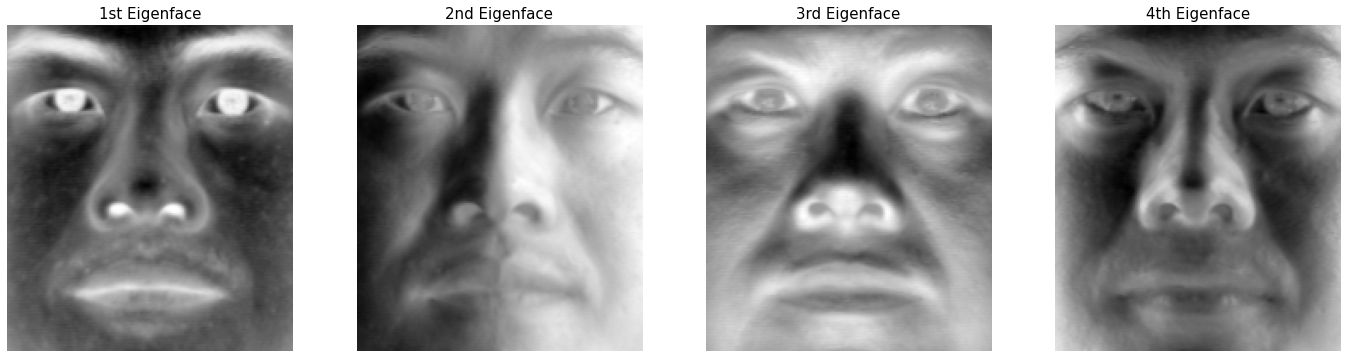

In [16]:
nfaces = 4

fig, axes = plt.subplots(1, nfaces, figsize=(6*nfaces, 6))

for i in range(len(axes)):
    axes[i].imshow(eigenfaces[i], cmap='gray')
    
    # label which eigenface it is
    if i == 0:
        lab = '1st'
    elif i == 1:
        lab = '2nd'
    elif i == 2:
        lab = '3rd'
    else:
        lab = '{}th'.format(i+1)
    axes[i].set_title(lab + ' Eigenface', fontsize=15)
    
    axes[i].axis('off')

plt.savefig(save_dir + 'yale_cropped_first_{}_eigenfaces.png'.format(nfaces), dpi=300, bbox_inches='tight')

plt.show()


#### Look at the average face!

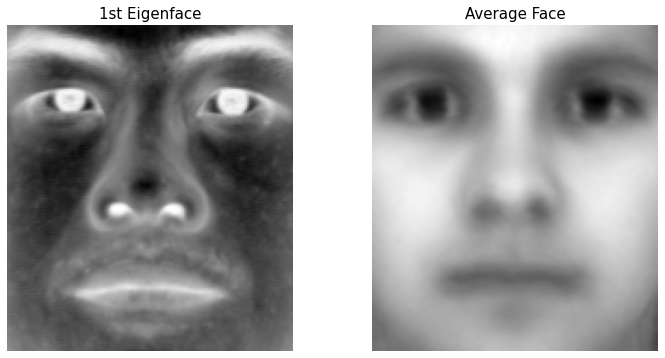

In [17]:
# note that first eigenface is very close to the average face!
# makes sense because the average face will dominate

avg_face = np.mean(crop_train, axis=(0, 1))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(eigenfaces[0], cmap='gray')
axes[0].set_title('1st Eigenface', fontsize=15)
axes[0].axis('off')

axes[1].imshow(avg_face, cmap='gray')
axes[1].set_title('Average Face', fontsize=15)
axes[1].axis('off')

plt.savefig(save_dir + 'cropped_avg_face_vs_1st_eigenface.png', dpi=300, bbox_inches='tight')
plt.show()


### Uncropped:

In [18]:
# get dimensions from the first pic
mm, nn = uncrop_train[0][0].shape

# get the eigenfaces (vectors) and reshape
eigenfaces_uc = [np.reshape(U_uc[:, i], (mm, nn)) for i in range(U_uc.shape[1])]


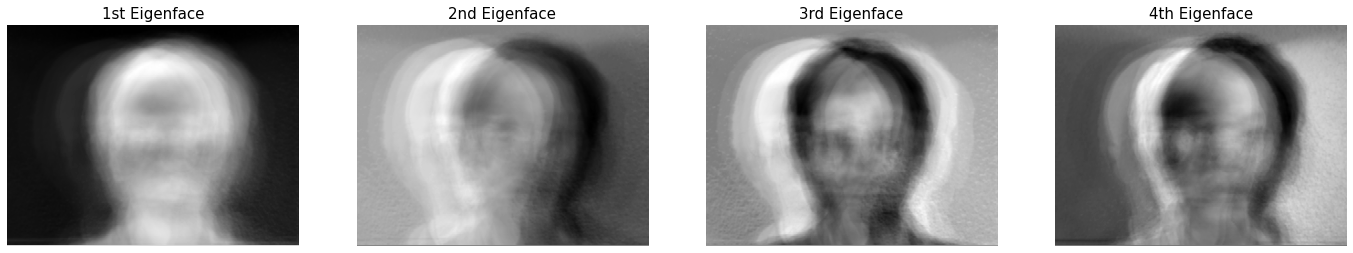

In [19]:
nfaces = 4

fig, axes = plt.subplots(1, nfaces, figsize=(6*nfaces, 6))

for i in range(len(axes)):
    axes[i].imshow(eigenfaces_uc[i], cmap='gray')
    
    # label which eigenface it is
    if i == 0:
        lab = '1st'
    elif i == 1:
        lab = '2nd'
    elif i == 2:
        lab = '3rd'
    else:
        lab = '{}th'.format(i+1)
    axes[i].set_title(lab + ' Eigenface', fontsize=15)
    
    axes[i].axis('off')

plt.savefig(save_dir + 'yale_uncropped_first_{}_eigenfaces.png'.format(nfaces), dpi=300, bbox_inches='tight')
plt.show()



#### Look at the average face!

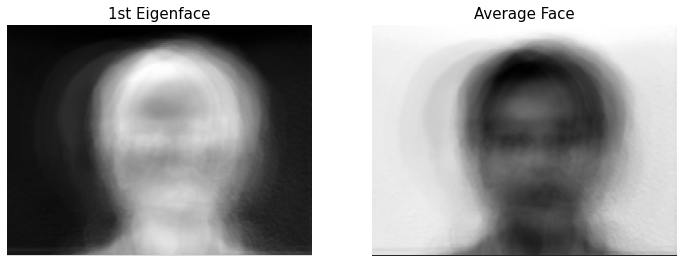

In [20]:
# note that first eigenface is very close to the average face!
# makes sense because the average face will dominate

avg_face = np.mean(uncrop_train, axis=(0, 1))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(eigenfaces_uc[0], cmap='gray')
axes[0].set_title('1st Eigenface', fontsize=15)
axes[0].axis('off')

axes[1].imshow(avg_face, cmap='gray')
axes[1].set_title('Average Face', fontsize=15)
axes[1].axis('off')

plt.savefig(save_dir + 'uncropped_avg_face_vs_1st_eigenface.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. What does the singular value spectrum look like and how many modes are necessary for good image reconstructions using the PCA basis?
(i.e. what is the rank r of the face space?)

### Cropped:

##### SOLUTION:
(for cropped) I think it's 64? Based on looking at the eigenvalue plots... how to determine this from the matrices themselves? Can you?? Is it 64 because there are 64 different pictures in each subfolder??

In [21]:
# # 70% of subjects

# print('63rd eigenvalue is {}'.format(S[62]))
# print('64th eigenvalue is {}'.format(S[63]))
# print('65th eigenvalue is {}'.format(S[64]))


In [22]:
# 70% of pics

print('44th eigenvalue is {}'.format(S[43]))
print('45th eigenvalue is {}'.format(S[44]))
print('46th eigenvalue is {}'.format(S[45]))


44th eigenvalue is 2034.8377452012157
45th eigenvalue is 964.0035632069666
46th eigenvalue is 1.1856249108654386e-09


In [23]:
# nbig_c = 64
nbig_c = 45

#### Plot the singular values:

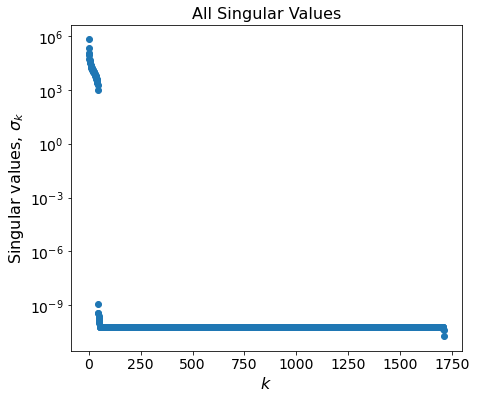

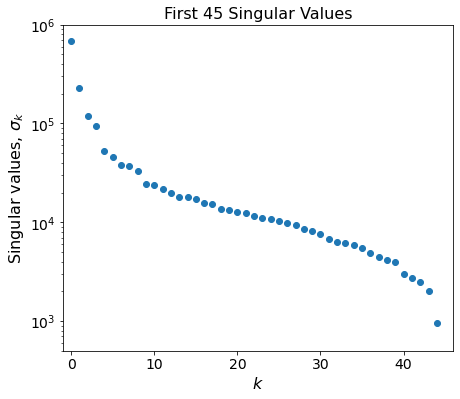

In [57]:
### all singular values ###

fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(np.arange(0, len(S)), S, color='C0', marker='o')
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('Singular values, $\sigma_k$', fontsize=16)
ax.set_xlabel('$k$', fontsize=16)
ax.set_title('All Singular Values', fontsize=16)

plt.savefig(save_dir + 'yale_cropped_ALL_singular_values.png', dpi=300, bbox_inches='tight')
plt.show()


### most important singular values ###
fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(np.arange(0, nbig_c), S[:nbig_c], color='C0', marker='o')
ax.set_yscale('log')
ax.set_ylim((5e2, 1e6))
ax.set_xlim(-1, nbig_c+1) 
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('Singular values, $\sigma_k$', fontsize=16)
ax.set_xlabel('$k$', fontsize=16)
ax.set_title('First {} Singular Values'.format(nbig_c), fontsize=16)

plt.savefig(save_dir + 'yale_cropped_BIGGEST_{}_singular_values.png'.format(nbig_c), dpi=300, bbox_inches='tight')
plt.show()



#### Bar plots of the average faces of each people projected onto eigenface space
# TODO: am I including this? (no for now...)

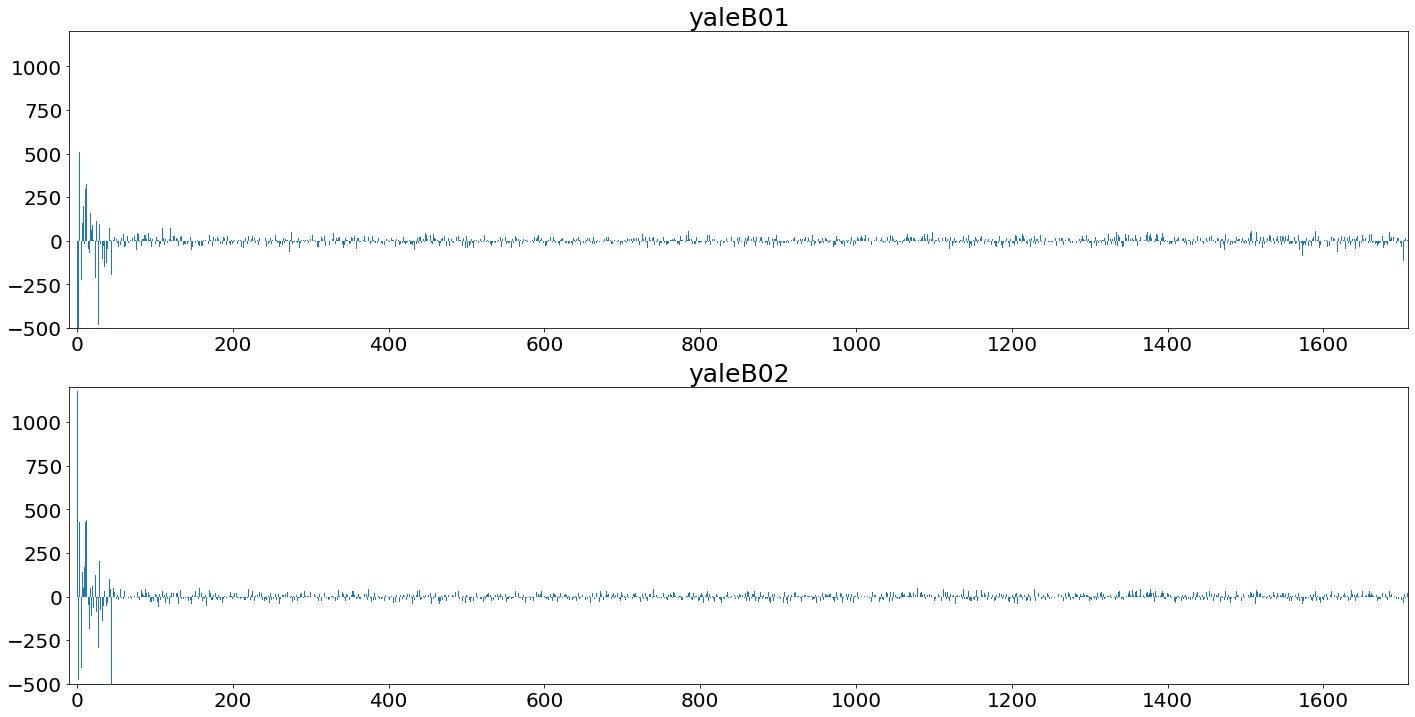

In [25]:
# to show: first two people, all modes

proj0_all = np.matmul(np.reshape(crop_train_avgs[0], (1, m*n)), U).flatten()
proj1_all = np.matmul(np.reshape(crop_train_avgs[1], (1, m*n)), U).flatten()

tsize = 25
fsize = 20

fig = plt.figure(figsize=(24, 12))

ax1 = fig.add_subplot(211)
ax1.set_title('yaleB01', fontsize=tsize)
ax1.tick_params(axis='both', labelsize=fsize)
ax1.bar(np.arange(1, len(S)), proj0_all[1:])
ax1.set_ylim((-500, 1200))
ax1.set_xlim(-10, len(S)-1)

ax2 = fig.add_subplot(212)
ax2.set_title('yaleB02', fontsize=tsize)
ax2.bar(np.arange(1, len(S)), proj1_all[1:])
ax2.tick_params(axis='both', labelsize=fsize)
ax2.set_ylim((-500, 1200))
ax2.set_xlim(-10, len(S)-1)

plt.savefig(save_dir + 'yale_cropped_0-1_proj_onto_ALL_eigfaces.png',
            dpi=300, bbox_inches='tight')
plt.show()


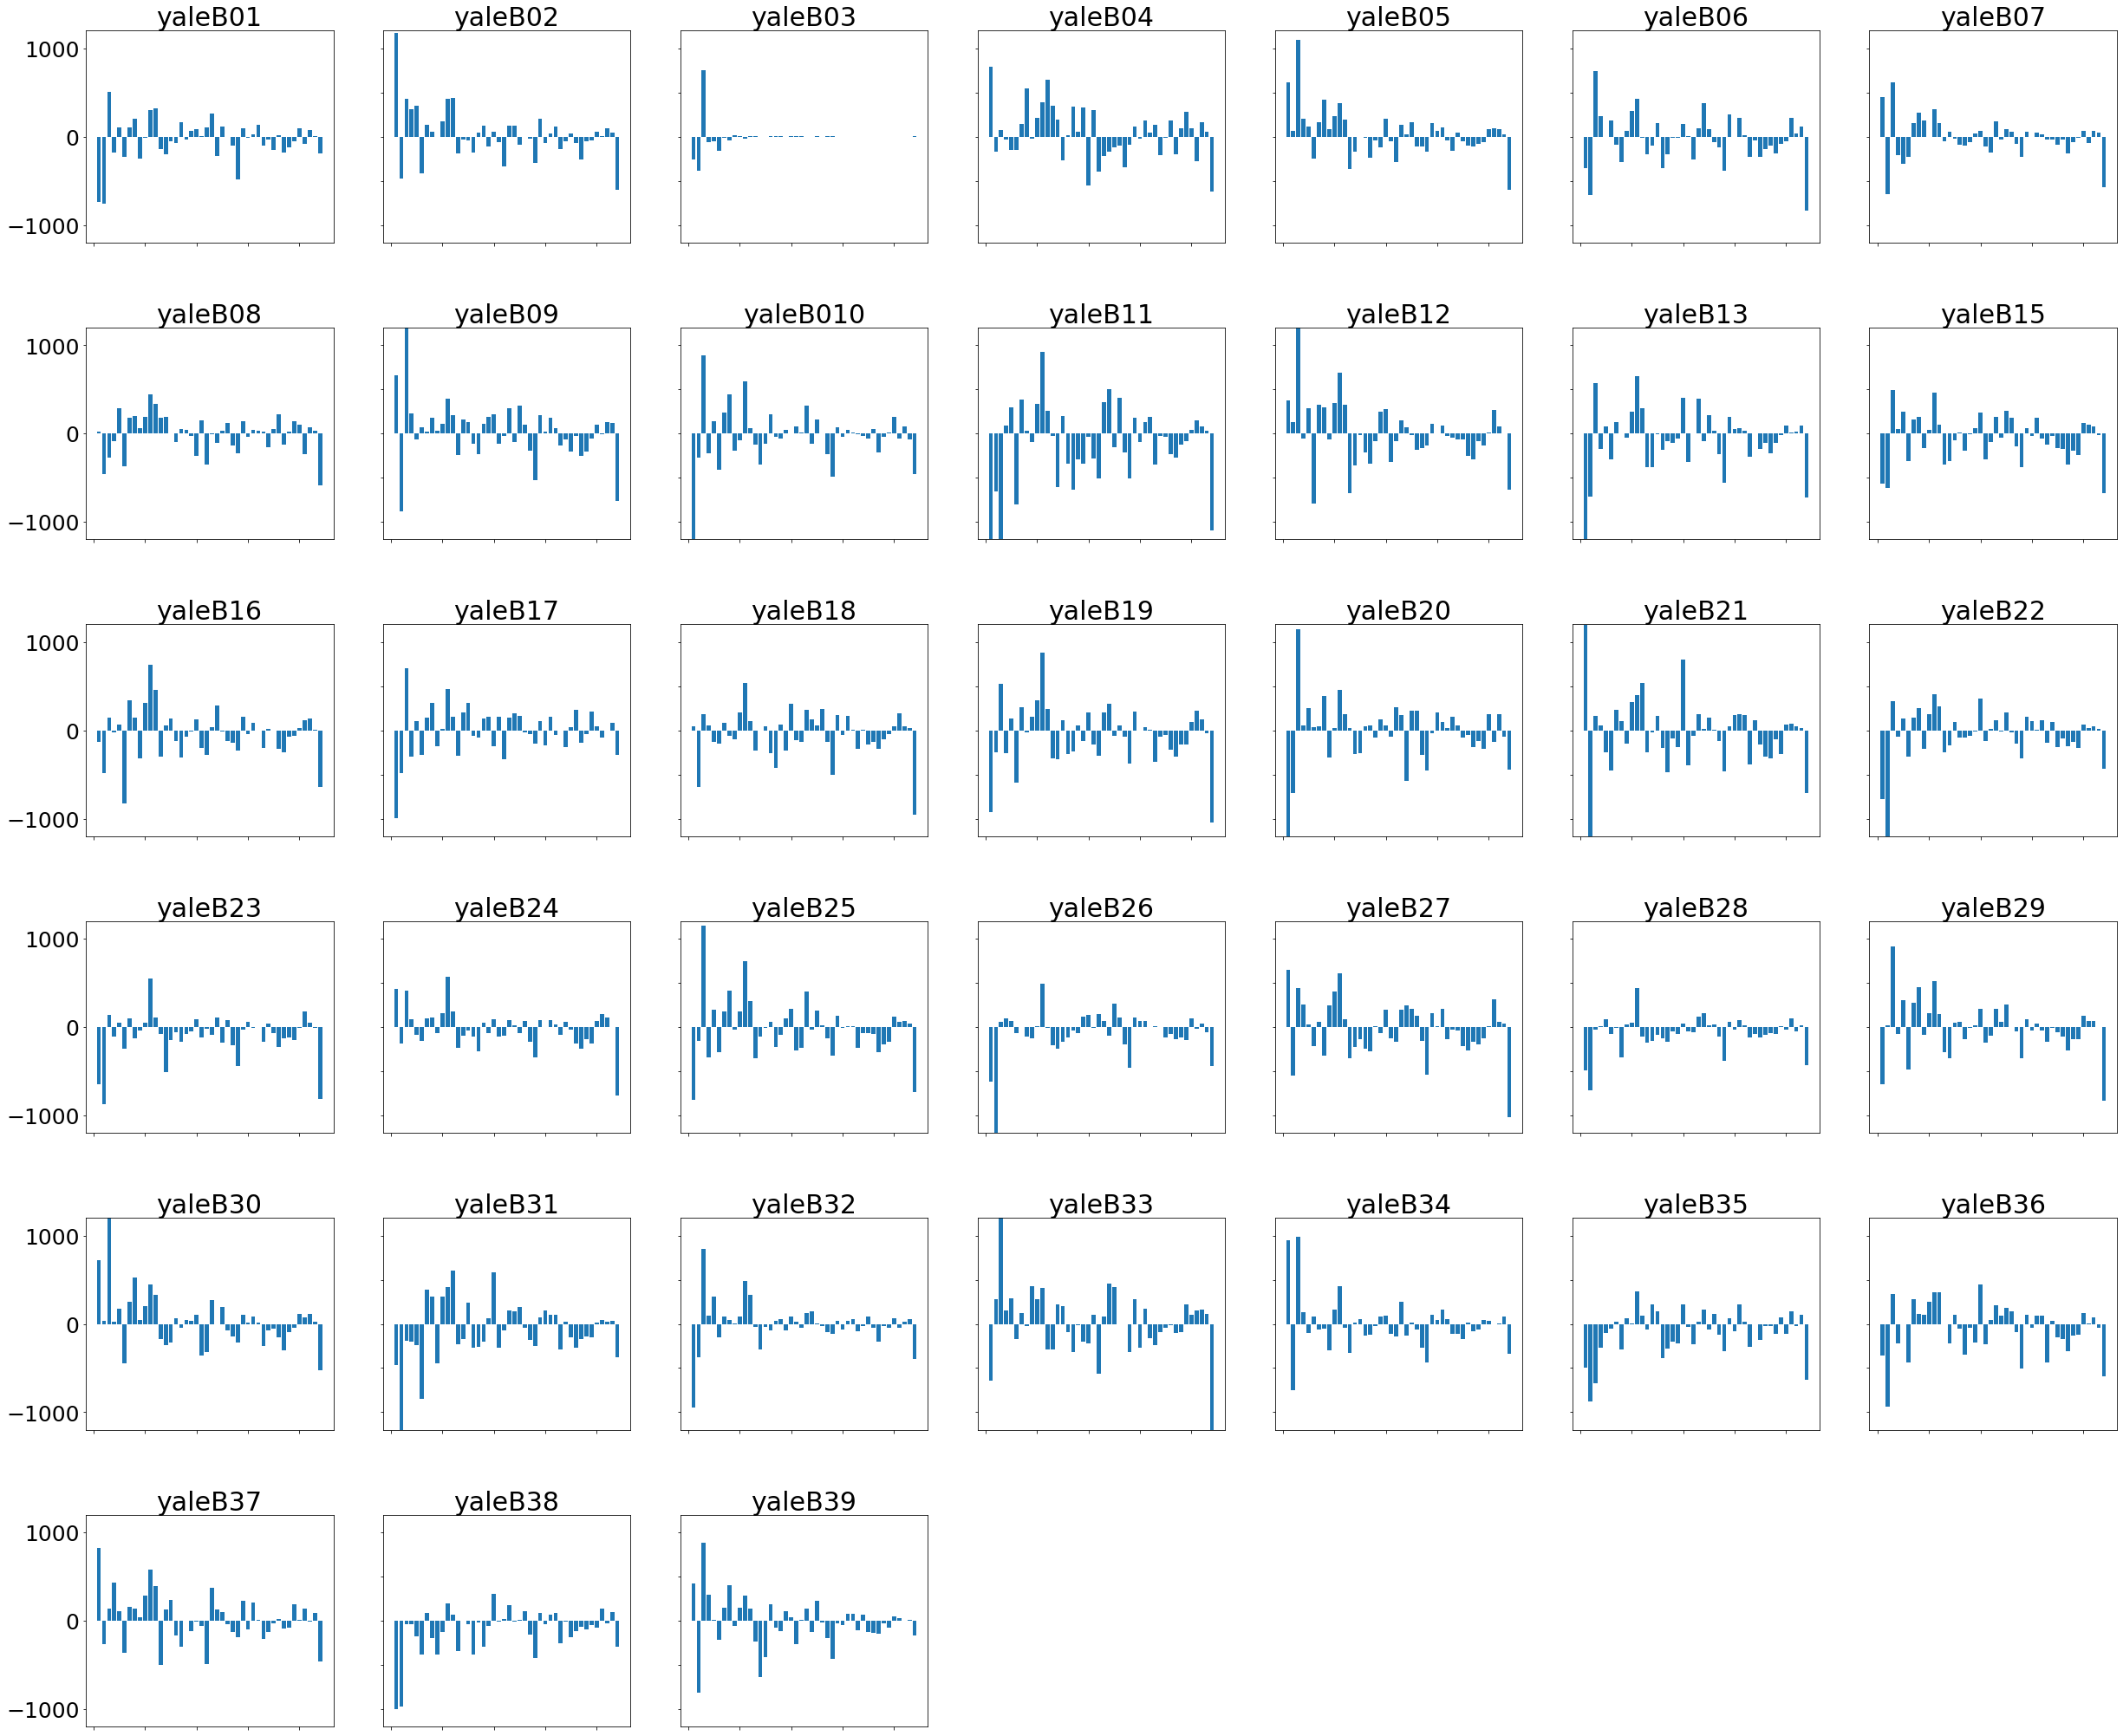

In [26]:
# all 38 people, biggest modes

projs = [np.matmul(np.reshape(x, (1, m*n)), U[:, :nbig_c]).flatten() 
         for x in crop_train_avgs]

nrow = 6
ncol = 7
tsize = 30
lsize = 25

fig, axes = plt.subplots(nrow, ncol, figsize=(6*ncol, 6*nrow))
plt.subplots_adjust(hspace=0.4)

for r in range(nrow):
    for c in range(ncol):
        i = c + (ncol)*r
        if i < len(crop_train_avgs):
            axes[r, c].bar(np.arange(1, nbig_c), projs[i][1:])
            if i < 10:
                axes[r, c].set_title('yaleB0{}'.format(i+1), fontsize=tsize)
            elif i > 12: # since B14 (i=13) is skipped
                axes[r, c].set_title('yaleB{}'.format(i+2), fontsize=tsize)
            else:
                axes[r, c].set_title('yaleB{}'.format(i+1), fontsize=tsize)
           
            axes[r, c].set_ylim((-1200, 1200))
            
            # only label y axis for the first column:
            if c == 0:
                axes[r, c].tick_params(axis='y', labelsize=lsize)
                axes[r, c].set_xticklabels([])

            else:
                axes[r, c].set_xticklabels([])
                axes[r, c].set_yticklabels([])
            
            
        else:
            axes[r, c].axis('off')

plt.savefig(save_dir + 'yale_cropped_ALL_proj_onto_2-{}_eigfaces.png'.format(nbig_c),
            dpi=300, bbox_inches='tight')
plt.show()


### Uncropped:

In [27]:
# # 70% of subjects

# print('102nd eigenvalue is {}'.format(S_uc[101]))
# print('103rd eigenvalue is {}'.format(S_uc[102]))
# print('104th eigenvalue is {}'.format(S_uc[103]))


In [28]:
# 70% of pics

print('110th eigenvalue is {}'.format(S_uc[109]))
print('111th eigenvalue is {}'.format(S_uc[110]))
print('112th eigenvalue is {}'.format(S_uc[111]))


110th eigenvalue is 2339.8190368868986
111th eigenvalue is 2181.449922807338
112th eigenvalue is 2.5508458360406795e-10


In [29]:
# nbig_uc = 103
nbig_uc = 111

#### Plot the singular values:

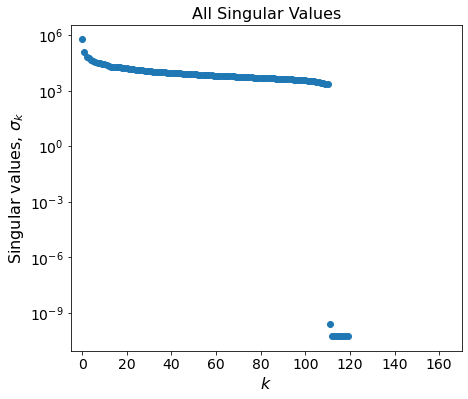

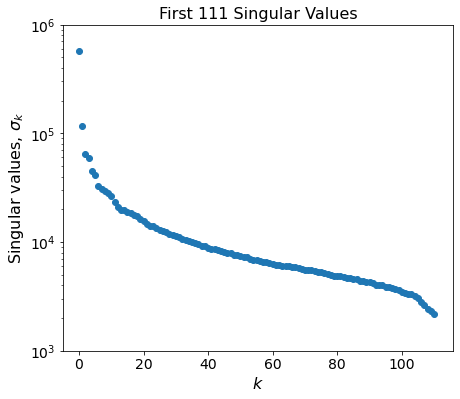

In [59]:
### all singular values ###

fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(np.arange(0, len(S_uc)), S_uc, color='C0', marker='o')
ax.set_yscale('log')
ax.set_xlim(-5, 170) 
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('Singular values, $\sigma_k$', fontsize=16)
ax.set_xlabel('$k$', fontsize=16)
ax.set_title('All Singular Values', fontsize=16)

plt.savefig(save_dir + 'yale_uncropped_ALL_singular_values.png', dpi=300, bbox_inches='tight')
plt.show()


### most important singular values ###
fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(np.arange(0, nbig_uc), S_uc[:nbig_uc], color='C0', marker='o')
ax.set_yscale('log')
ax.set_ylim((1e3, 1e6))
ax.set_xlim(-5, nbig_uc+5) 
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('Singular values, $\sigma_k$', fontsize=16)
ax.set_xlabel('$k$', fontsize=16)
ax.set_title('First {} Singular Values'.format(nbig_uc), fontsize=16)

plt.savefig(save_dir + 'yale_uncropped_BIGGEST_{}_singular_values.png'.format(nbig_uc), dpi=300, bbox_inches='tight')
plt.show()



#### Bar plots of the average faces of each people projected onto eigenface space

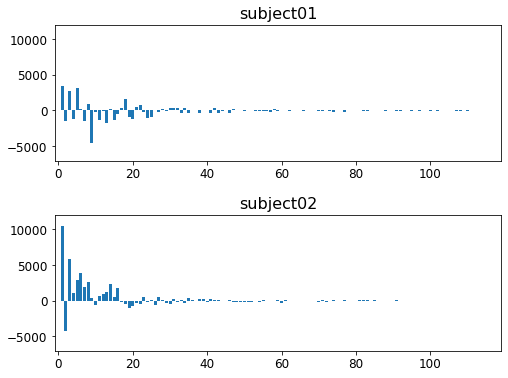

In [31]:
# to show: first two people, all modes

proj0_uc_all = np.matmul(np.reshape(uncrop_train_avgs[0], (1, mm*nn)), U_uc).flatten()
proj1_uc_all = np.matmul(np.reshape(uncrop_train_avgs[1], (1, mm*nn)), U_uc).flatten()

tsize = 16
fsize = 12

fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(211)
ax1.set_title('subject01', fontsize=tsize)
ax1.tick_params(axis='both', labelsize=fsize)
ax1.bar(np.arange(1, len(S_uc)), proj0_uc_all[1:])
ax1.set_ylim((-7000, 12000))
ax1.set_xlim(-1, len(S_uc)-1)

ax2 = fig.add_subplot(212)
ax2.set_title('subject02', fontsize=tsize)
ax2.bar(np.arange(1, len(S_uc)), proj1_uc_all[1:])
ax2.tick_params(axis='both', labelsize=fsize)
ax2.set_ylim((-7000, 12000))
ax2.set_xlim(-1, len(S_uc)-1)

plt.savefig(save_dir + 'yale_uncropped_0-1_proj_onto_ALL_eigfaces.png',
            dpi=300, bbox_inches='tight')
plt.show()


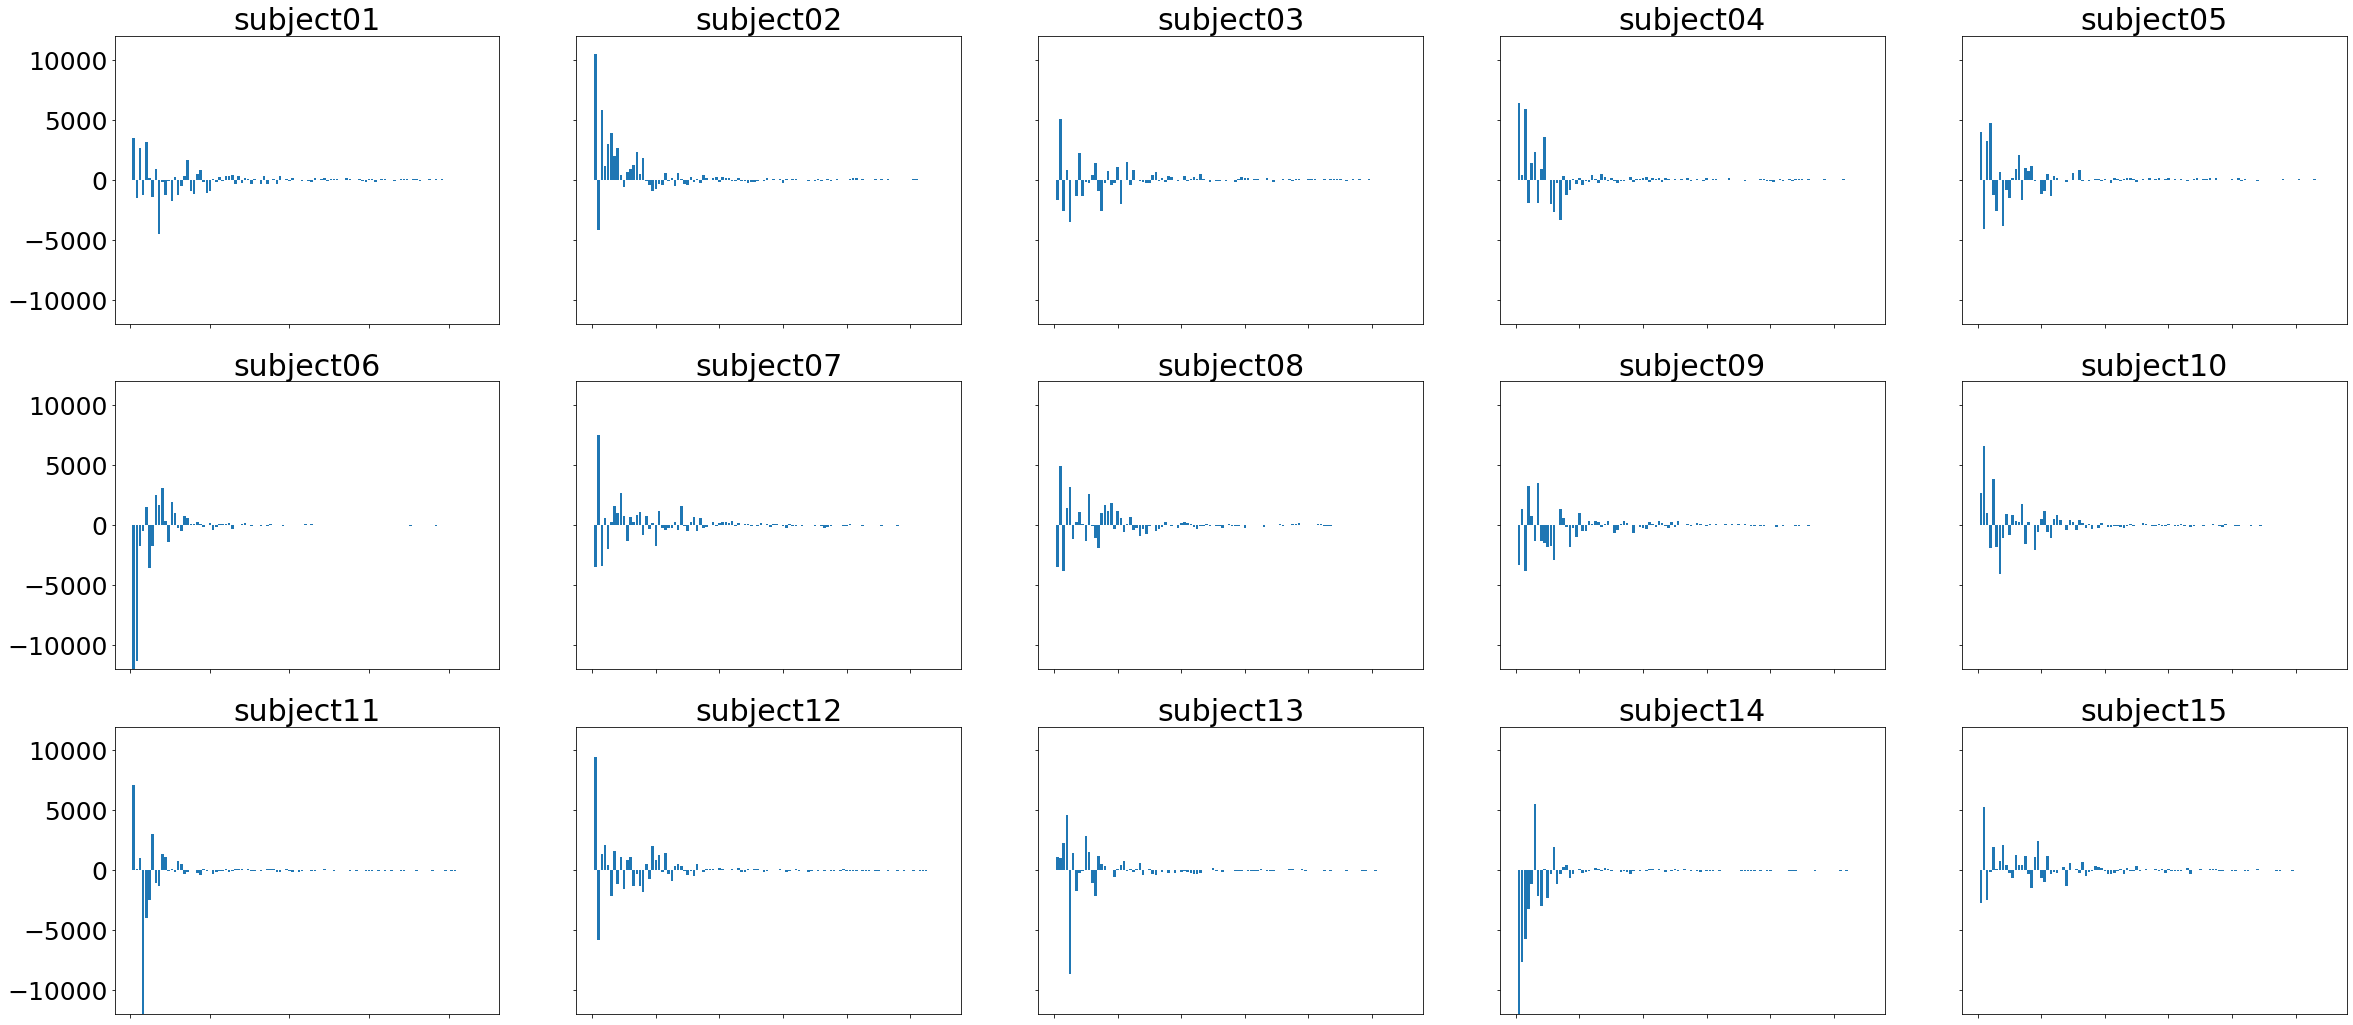

In [32]:
# all 15 subjects, biggest modes

projs_uc = [np.matmul(np.reshape(x, (1, mm*nn)), U_uc[:, :nbig_uc]).flatten() 
            for x in uncrop_train_avgs]

nrow = 3
ncol = 5
tsize = 30
lsize = 25

fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 6*nrow))

for r in range(nrow):
    for c in range(ncol):
        i = c + (ncol)*r
        if i < len(uncrop_train_avgs):
            axes[r, c].bar(np.arange(1, nbig_uc), projs_uc[i][1:])
            if i < 9:
                axes[r, c].set_title('subject0{}'.format(i+1), fontsize=tsize)
            else:
                axes[r, c].set_title('subject{}'.format(i+1), fontsize=tsize)

            axes[r, c].set_ylim((-12000, 12000))
            axes[r, c].set_xlim((-5, nbig_uc+5))
              
            # only label y axis for the first column:
            if c == 0:
                axes[r, c].tick_params(axis='both', labelsize=lsize)
                axes[r, c].set_xticklabels([])

            else:
                axes[r, c].set_xticklabels([])
                axes[r, c].set_yticklabels([])
            
            
        else:
            axes[r, c].axis('off')

plt.savefig(save_dir + 'yale_uncropped_ALL_proj_onto_2-{}_eigfaces.png'.format(nbig_uc),
            dpi=300, bbox_inches='tight')
plt.show()


## 4. Compare the difference between the cropped (and aligned) versus uncropped images in terms of singular value decay and reconstruction capabilities.

## Reconstructions:

### Cropped

#### Quantitatively determine how many modes are needed
Guesses for number of modes: 1, 8, 16, 32, 64, 500; these are chosen arbitrarily except for 64, which was the number of significant modes based on the eigenvalue spectrum.

In [33]:
threshold = 0.9999
S_sq = S**2

# equation: sum of first t eigenvalues divided by sum of all eigenvalues >= threshold
n_modes = [1, 8, 16, 32, 45, 64, 500]
for t in n_modes:
    pct = np.sum(S_sq[:t])/np.sum(S_sq)
    print('for {t} modes, the fraction >= threshold of {th}%: {b}'.format(t=t, th=threshold*100.,
                                                                         b=(pct >= threshold)))


for 1 modes, the fraction >= threshold of 99.99%: False
for 8 modes, the fraction >= threshold of 99.99%: False
for 16 modes, the fraction >= threshold of 99.99%: False
for 32 modes, the fraction >= threshold of 99.99%: False
for 45 modes, the fraction >= threshold of 99.99%: True
for 64 modes, the fraction >= threshold of 99.99%: True
for 500 modes, the fraction >= threshold of 99.99%: True


In [34]:
# nmode_c = 64
nmode_c = 45

#### Reconstruct some of the training data:

In [35]:
vec1 = np.reshape(crop_train_avgs[0], (1, 32256))
proj1 = np.matmul(vec1, U)
proj1_ef = np.matmul(vec1, U[:, :nmode_c])

recon1_all = np.matmul(U, np.transpose(proj1))
recon1_all_rs = np.reshape(recon1_all, (192, 168))

recon1_ef = np.matmul(U[:, :nmode_c], np.transpose(proj1_ef))
recon1_ef_rs = np.reshape(recon1_ef, (192, 168))

In [36]:
vec2 = np.reshape(crop_train_avgs[1], (1, 32256))
proj2 = np.matmul(vec2, U)
proj2_ef = np.matmul(vec2, U[:, :nmode_c])

recon2_all = np.matmul(U, np.transpose(proj1))
recon2_all_rs = np.reshape(recon2_all, (192, 168))

recon2_ef = np.matmul(U[:, :nmode_c], np.transpose(proj2_ef))
recon2_ef_rs = np.reshape(recon2_ef, (192, 168))

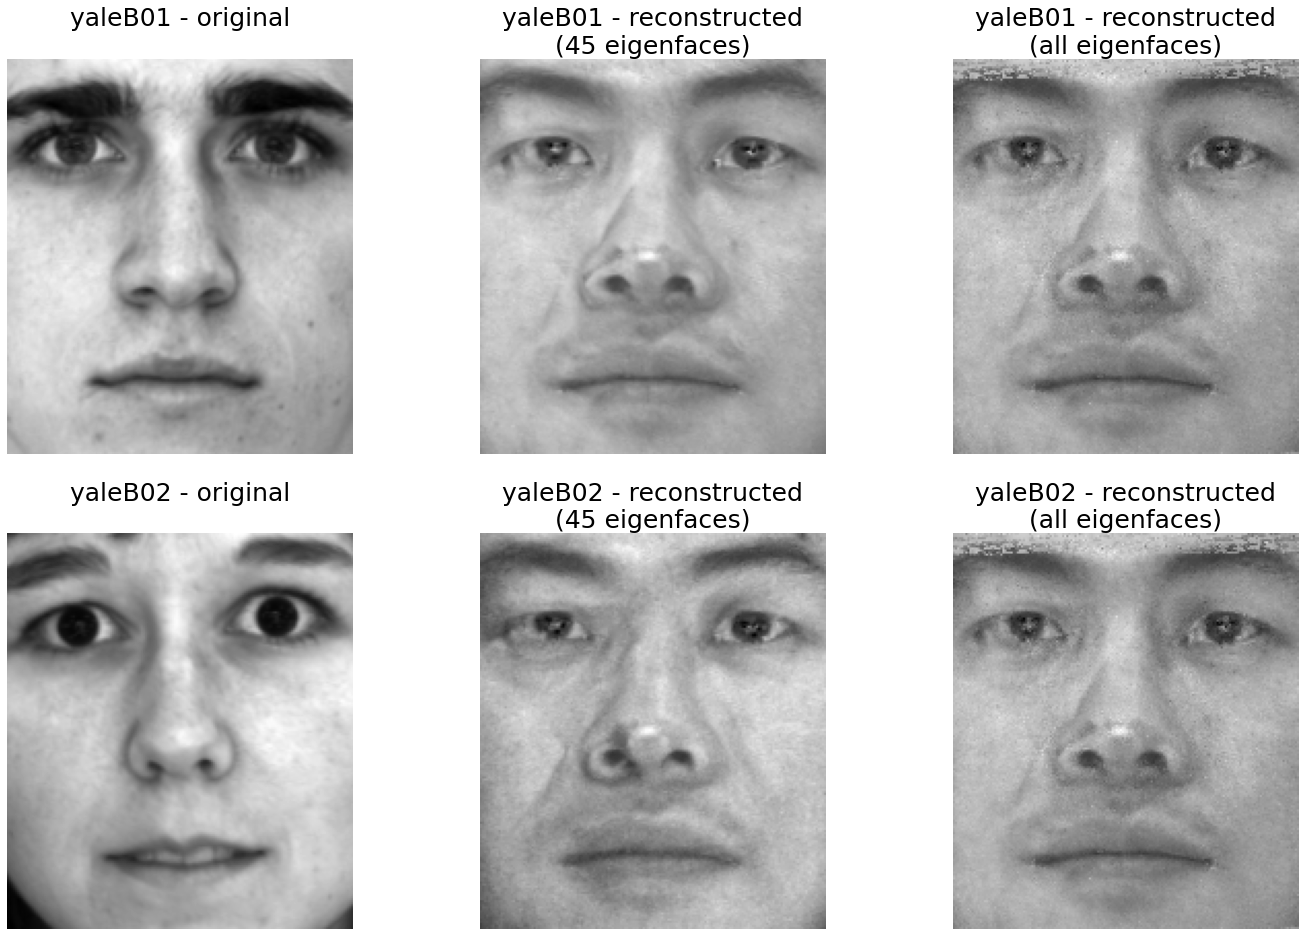

In [37]:
tsize = 25

fig = plt.figure(figsize=(24, 16))

### yale B01: ### 

ax1 = fig.add_subplot(231)
ax1.imshow(crop_train_avgs[0], cmap='gray')
ax1.set_title('yaleB01 - original\n ', fontsize=tsize)
ax1.axis('off')

ax2 = fig.add_subplot(233)
ax2.imshow(recon1_all_rs, cmap='gray')
ax2.set_title('yaleB01 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax2.axis('off')

ax3 = fig.add_subplot(232)
ax3.imshow(recon1_ef_rs, cmap='gray')
ax3.set_title('yaleB01 - reconstructed\n({} eigenfaces)'.format(nmode_c), fontsize=tsize)
ax3.axis('off')

### yale B02: ### 

ax4 = fig.add_subplot(234)
ax4.imshow(crop_train_avgs[1], cmap='gray')
ax4.set_title('yaleB02 - original\n ', fontsize=tsize)
ax4.axis('off')

ax5 = fig.add_subplot(236)
ax5.imshow(recon2_all_rs, cmap='gray')
ax5.set_title('yaleB02 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax5.axis('off')

ax6 = fig.add_subplot(235)
ax6.imshow(recon2_ef_rs, cmap='gray')
ax6.set_title('yaleB02 - reconstructed\n({} eigenfaces)'.format(nmode_c), fontsize=tsize)
ax6.axis('off')

plt.savefig(save_dir + 'yaleB01-02_reconstructed_{}_modes.png'.format(nmode_c), dpi=300, bbox_inches='tight')
plt.show()


#### Reconstruct some of the testing data:

In [60]:
vec1_test = np.reshape(crop_test[-2][-1], (1, 32256))
proj1_test = np.matmul(vec1_test, U)
proj1_ef_test = np.matmul(vec1_test, U[:, :nmode_c])

recon1_all_test = np.matmul(U, np.transpose(proj1_test))
recon1_all_rs_test = np.reshape(recon1_all_test, (192, 168))

recon1_ef_test = np.matmul(U[:, :nmode_c], np.transpose(proj1_ef_test))
recon1_ef_rs_test = np.reshape(recon1_ef_test, (192, 168))

In [61]:
vec2_test = np.reshape(crop_test[-1][-1], (1, 32256))
proj2_test = np.matmul(vec2_test, U)
proj2_ef_test = np.matmul(vec2_test, U[:, :nmode_c])

recon2_all_test = np.matmul(U, np.transpose(proj2_test))
recon2_all_rs_test = np.reshape(recon2_all_test, (192, 168))

recon2_ef_test = np.matmul(U[:, :nmode_c], np.transpose(proj2_ef_test))
recon2_ef_rs_test = np.reshape(recon2_ef_test, (192, 168))

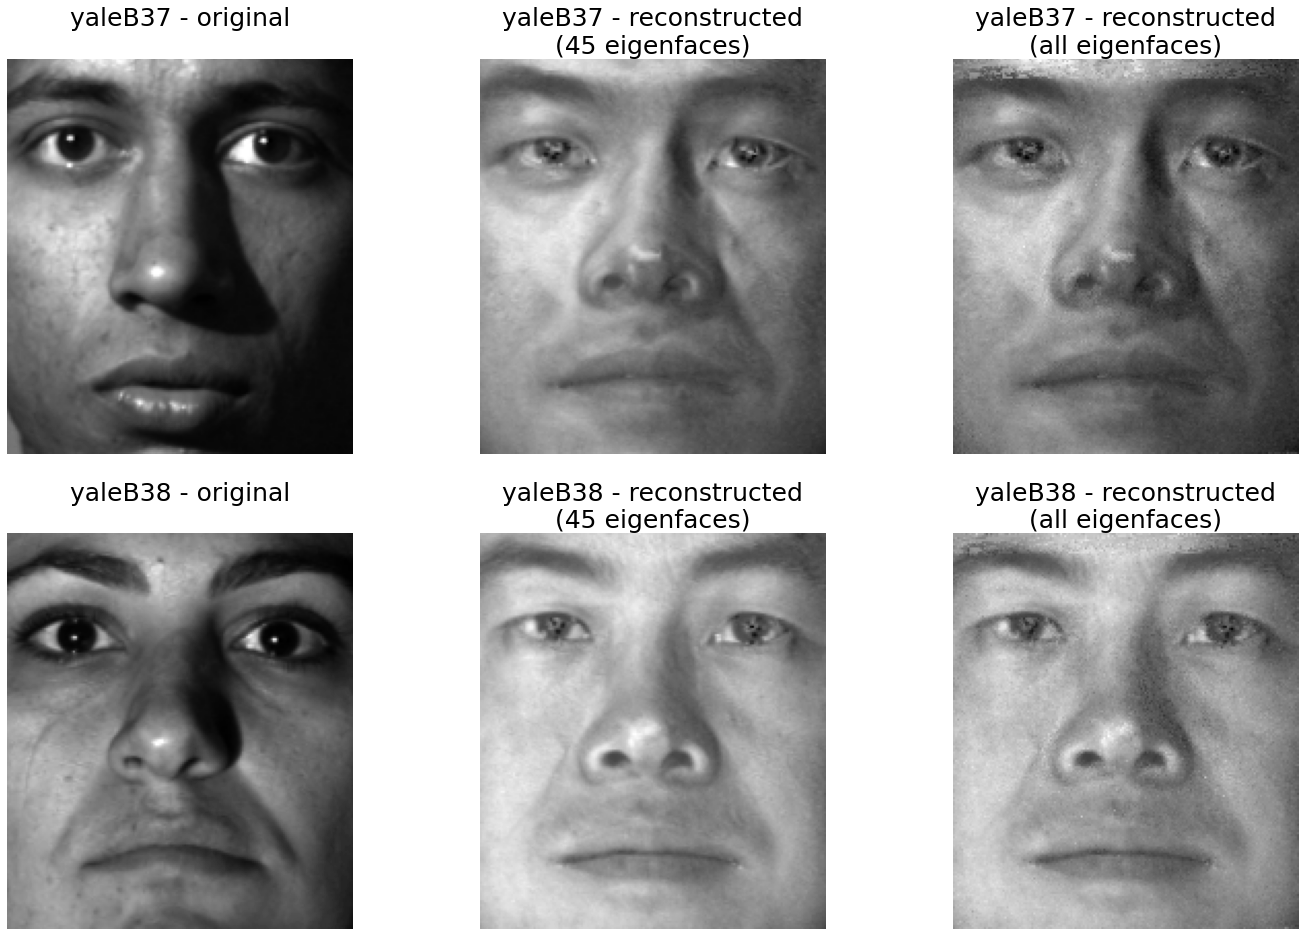

In [62]:
tsize = 25

fig = plt.figure(figsize=(24, 16))

### yale B37: ### 

ax1 = fig.add_subplot(231)
ax1.imshow(crop_test[-2][-1], cmap='gray')
ax1.set_title('yaleB37 - original\n ', fontsize=tsize)
ax1.axis('off')

ax2 = fig.add_subplot(233)
ax2.imshow(recon1_all_rs_test, cmap='gray')
ax2.set_title('yaleB37 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax2.axis('off')

ax3 = fig.add_subplot(232)
ax3.imshow(recon1_ef_rs_test, cmap='gray')
ax3.set_title('yaleB37 - reconstructed\n({} eigenfaces)'.format(nmode_c), fontsize=tsize)
ax3.axis('off')

### yale B38: ### 

ax4 = fig.add_subplot(234)
ax4.imshow(crop_test[-1][-1], cmap='gray')
ax4.set_title('yaleB38 - original\n ', fontsize=tsize)
ax4.axis('off')

ax5 = fig.add_subplot(236)
ax5.imshow(recon2_all_rs_test, cmap='gray')
ax5.set_title('yaleB38 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax5.axis('off')

ax6 = fig.add_subplot(235)
ax6.imshow(recon2_ef_rs_test, cmap='gray')
ax6.set_title('yaleB38 - reconstructed\n({} eigenfaces)'.format(nmode_c), fontsize=tsize)
ax6.axis('off')


plt.savefig(save_dir + 'yaleB37-38_reconstructed_{}_modes.png'.format(nmode_c), dpi=300, bbox_inches='tight')
plt.show()


### Uncropped

#### Quantitatively determine how many modes are needed
Guesses for number of modes: 1, 8, 16, 32, 64, 75, 90, 103, 105; again, these are chosen arbitrarily except for 103, which was the number of significant modes based on the eigenvalue spectrum.

In [41]:
threshold = 0.9999
S_sq_uc = S_uc**2

# equation: sum of first t eigenvalues divided by sum of all eigenvalues >= threshold
n_modes_uc = [1, 8, 16, 32, 64, 75, 90, 103, 105, 111]
for t in n_modes_uc:
    pct_uc = np.sum(S_sq_uc[:t])/np.sum(S_sq_uc)
    print('for {t} modes, the fraction >= threshold of {th}%: {b}'.format(t=t, th=threshold*100,
                                                                         b=(pct_uc >= threshold)))


for 1 modes, the fraction >= threshold of 99.99%: False
for 8 modes, the fraction >= threshold of 99.99%: False
for 16 modes, the fraction >= threshold of 99.99%: False
for 32 modes, the fraction >= threshold of 99.99%: False
for 64 modes, the fraction >= threshold of 99.99%: False
for 75 modes, the fraction >= threshold of 99.99%: False
for 90 modes, the fraction >= threshold of 99.99%: False
for 103 modes, the fraction >= threshold of 99.99%: False
for 105 modes, the fraction >= threshold of 99.99%: False
for 111 modes, the fraction >= threshold of 99.99%: True


In [42]:
# nmode_uc = 75
nmode_uc = 111

#### Reconstruct some of the training data:

In [43]:
vec1_uc = np.reshape(uncrop_train[0][0], (1, 77760))
proj1_uc = np.matmul(vec1_uc, U_uc)
proj1_ef_uc = np.matmul(vec1_uc, U_uc[:, :nmode_uc])

recon1_all_uc = np.matmul(U_uc, np.transpose(proj1_uc))
recon1_all_rs_uc = np.reshape(recon1_all_uc, (243, 320))

recon1_ef_uc = np.matmul(U_uc[:, :nmode_uc], np.transpose(proj1_ef_uc))
recon1_ef_rs_uc = np.reshape(recon1_ef_uc, (243, 320))


In [44]:
vec2_uc = np.reshape(uncrop_train[1][0], (1, 77760))
proj2_uc = np.matmul(vec2_uc, U_uc)
proj2_ef_uc = np.matmul(vec2_uc, U_uc[:, :nmode_uc])

recon2_all_uc = np.matmul(U_uc, np.transpose(proj2_uc))
recon2_all_rs_uc = np.reshape(recon2_all_uc, (243, 320))

recon2_ef_uc = np.matmul(U_uc[:, :nmode_uc], np.transpose(proj2_ef_uc))
recon2_ef_rs_uc = np.reshape(recon2_ef_uc, (243, 320))


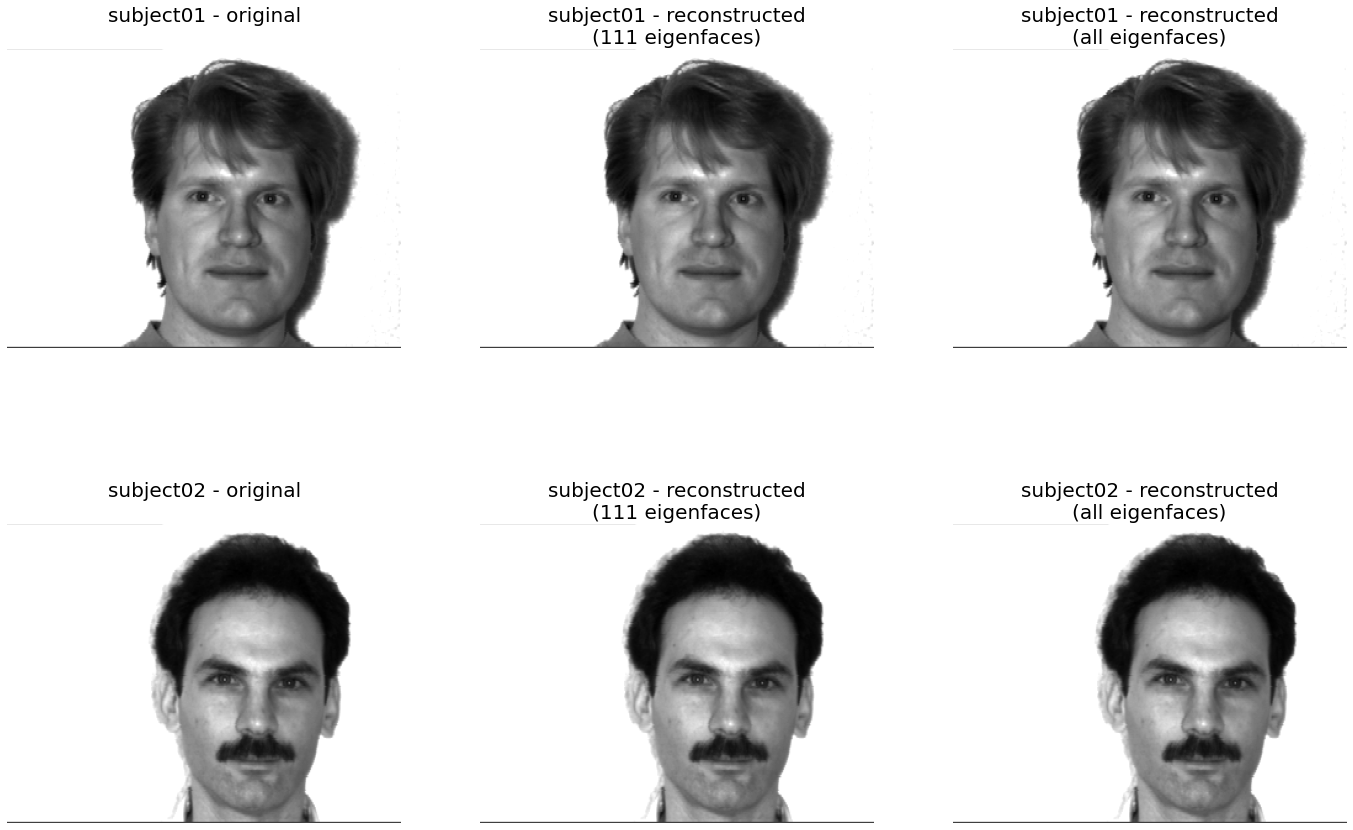

In [45]:
tsize = 20

fig = plt.figure(figsize=(24, 16))

### subject 01: ### 

ax1 = fig.add_subplot(231)
ax1.imshow(uncrop_train[0][0], cmap='gray')
ax1.set_title('subject01 - original\n ', fontsize=tsize)
ax1.axis('off')

ax2 = fig.add_subplot(233)
ax2.imshow(recon1_all_rs_uc, cmap='gray')
ax2.set_title('subject01 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax2.axis('off')

ax4 = fig.add_subplot(232)
ax4.imshow(recon1_ef_rs_uc, cmap='gray')
ax4.set_title('subject01 - reconstructed\n({} eigenfaces)'.format(nmode_uc), fontsize=tsize)
ax4.axis('off')

### subject 02: ### 

ax5 = fig.add_subplot(234)
ax5.imshow(uncrop_train[1][0], cmap='gray')
ax5.set_title('subject02 - original\n ', fontsize=tsize)
ax5.axis('off')

ax6 = fig.add_subplot(236)
ax6.imshow(recon2_all_rs_uc, cmap='gray')
ax6.set_title('subject02 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax6.axis('off')

axef = fig.add_subplot(235)
axef.imshow(recon2_ef_rs_uc, cmap='gray')
axef.set_title('subject02 - reconstructed\n({} eigenfaces)'.format(nmode_uc), fontsize=tsize)
axef.axis('off')

plt.savefig(save_dir + 'subject01-02_reconstructed_{}_modes.png'.format(nmode_uc), dpi=300, bbox_inches='tight')
plt.show()


#### Reconstruct some of the testing data:

In [63]:
vec1_uc_test = np.reshape(uncrop_test[-2][-1], (1, 77760))
proj1_uc_test = np.matmul(vec1_uc_test, U_uc)
proj1_ef_uc_test = np.matmul(vec1_uc_test, U_uc[:, :nmode_uc])

recon1_all_uc_test = np.matmul(U_uc, np.transpose(proj1_uc_test))
recon1_all_rs_uc_test = np.reshape(recon1_all_uc_test, (243, 320))

recon1_ef_uc_test = np.matmul(U_uc[:, :nmode_uc], np.transpose(proj1_ef_uc_test))
recon1_ef_rs_uc_test = np.reshape(recon1_ef_uc_test, (243, 320))


In [64]:
vec2_uc_test = np.reshape(uncrop_test[-1][-1], (1, 77760))
proj2_uc_test = np.matmul(vec2_uc_test, U_uc)
proj2_ef_uc_test = np.matmul(vec2_uc_test, U_uc[:, :nmode_uc])

recon2_all_uc_test = np.matmul(U_uc, np.transpose(proj2_uc_test))
recon2_all_rs_uc_test = np.reshape(recon2_all_uc_test, (243, 320))

recon2_ef_uc_test = np.matmul(U_uc[:, :nmode_uc], np.transpose(proj2_ef_uc_test))
recon2_ef_rs_uc_test = np.reshape(recon2_ef_uc_test, (243, 320))


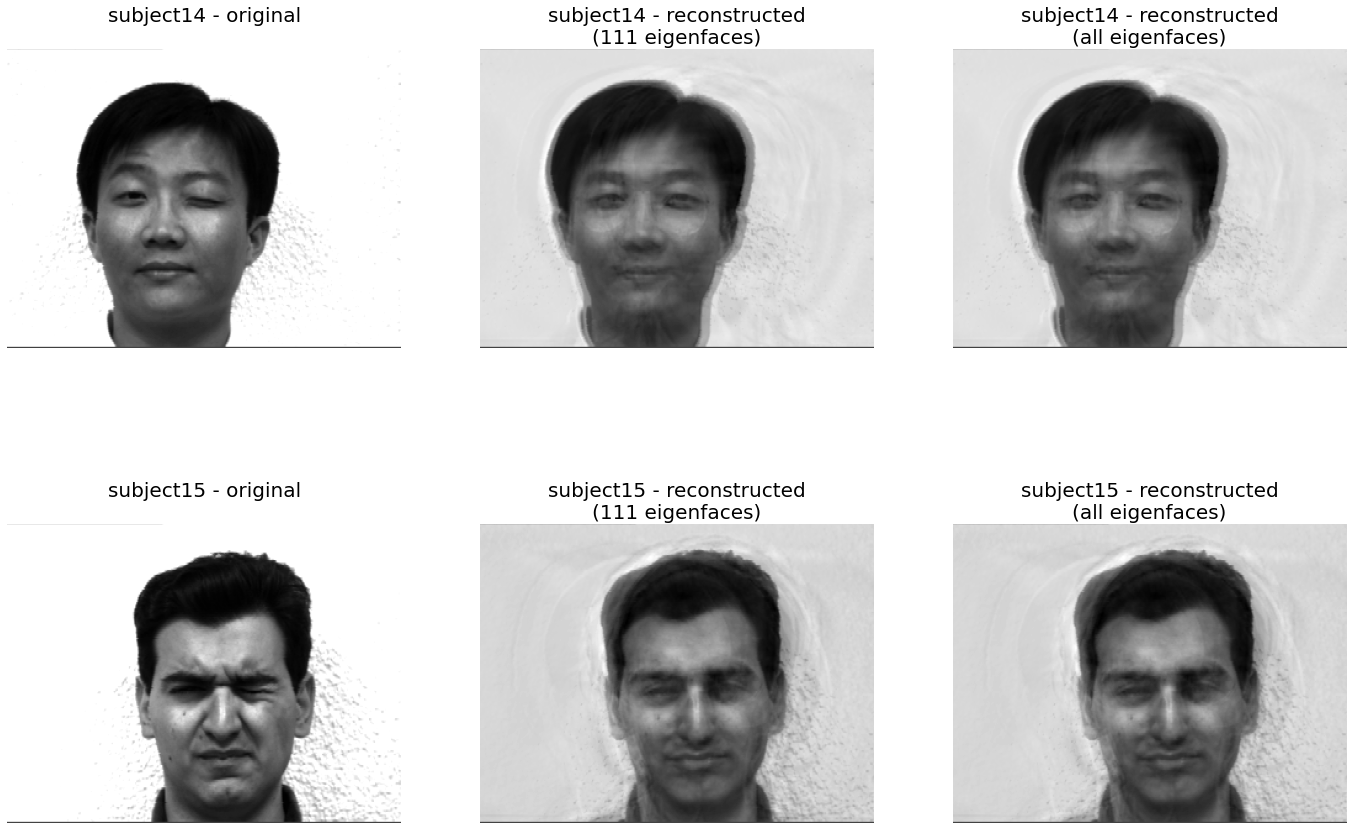

In [65]:
tsize = 20

fig = plt.figure(figsize=(24, 16))

### subject 14: ### 

ax1 = fig.add_subplot(231)
ax1.imshow(uncrop_test[-2][-1], cmap='gray')
ax1.set_title('subject14 - original\n ', fontsize=tsize)
ax1.axis('off')

ax2 = fig.add_subplot(233)
ax2.imshow(recon1_all_rs_uc_test, cmap='gray')
ax2.set_title('subject14 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax2.axis('off')

ax3 = fig.add_subplot(232)
ax3.imshow(recon1_ef_rs_uc_test, cmap='gray')
ax3.set_title('subject14 - reconstructed\n({} eigenfaces)'.format(nmode_uc), fontsize=tsize)
ax3.axis('off')

### subject 15: ### 

ax5 = fig.add_subplot(234)
ax5.imshow(uncrop_test[-1][-1], cmap='gray')
ax5.set_title('subject15 - original\n ', fontsize=tsize)
ax5.axis('off')

ax6 = fig.add_subplot(236)
ax6.imshow(recon2_all_rs_uc_test, cmap='gray')
ax6.set_title('subject15 - reconstructed\n(all eigenfaces)', fontsize=tsize)
ax6.axis('off')

ax7 = fig.add_subplot(235)
ax7.imshow(recon2_ef_rs_uc_test, cmap='gray')
ax7.set_title('subject15 - reconstructed\n({} eigenfaces)'.format(nmode_uc), fontsize=tsize)
ax7.axis('off')

plt.savefig(save_dir + 'subject14-15_reconstructed_{}.png'.format(nmode_uc), dpi=300, bbox_inches='tight')
plt.show()


## SVD Decay:

In [50]:
tsize = 20
fsize = 18
lsize = 16

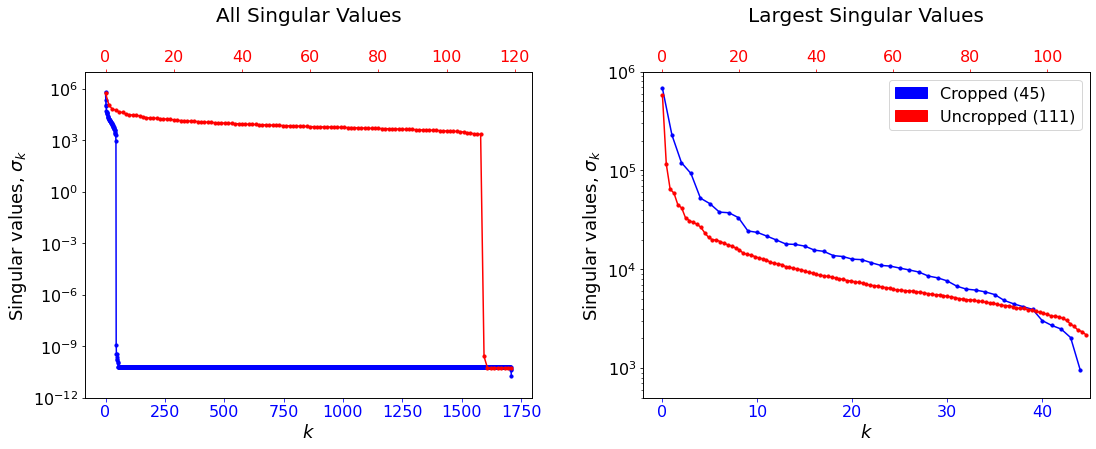

In [54]:
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0.25)

### all: ###

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, len(S)), S, color='b', label='Cropped')
ax1.scatter(np.arange(0, len(S)), S, s=10, color='b', marker='o', label='Cropped')
ax1.set_yscale('log')
ax1.set_ylabel('Singular values, $\sigma_k$', fontsize=fsize)
ax1.set_xlabel('$k$', fontsize=fsize)
ax1.set_ylim((1e-12, 1e7))

ax1.tick_params(axis='both', labelsize=lsize)
ax1.tick_params(axis='x', color='b', labelcolor='b')
ax1.set_title('All Singular Values\n ', fontsize=tsize)

ax2 = ax1.twiny()
ax2.plot(np.arange(0, len(S_uc)), S_uc, color='r', label='Uncropped')
ax2.scatter(np.arange(0, len(S_uc)), S_uc, s=10, color='r', marker='o', label='Uncropped')
ax2.set_yscale('log')
ax2.set_ylabel('Singular values, $\sigma_k$', fontsize=fsize)
ax2.tick_params(axis='both', labelsize=lsize)
ax2.tick_params(axis='x', color='r', labelcolor='r')

### largest: ###

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, nmode_c), S[:nmode_c], color='b', label='Cropped')
ax2.scatter(np.arange(0, nmode_c), S[:nmode_c], s=10, color='b', marker='o', label='Cropped')
ax2.set_yscale('log')
ax2.set_ylabel('Singular values, $\sigma_k$', fontsize=fsize)
ax2.set_xlabel('$k$', fontsize=fsize)
ax2.set_ylim((5e2, 1e6))
ax2.set_xlim((-(5/nmode_uc)*nmode_c, nmode_c))
ax2.tick_params(axis='both', labelsize=lsize)
ax2.tick_params(axis='x', color='b', labelcolor='b')
ax2.set_title('Largest Singular Values\n ', fontsize=tsize)

ax3 = ax2.twiny()
ax3.plot(np.arange(0, nmode_uc), S_uc[:nmode_uc], color='r', label='Uncropped')
ax3.scatter(np.arange(0, nmode_uc), S_uc[:nmode_uc], s=10, color='r', marker='o', label='Uncropped')
ax3.set_yscale('log')
ax3.set_xlim((-5, nmode_uc))
ax3.set_ylabel('Singular values, $\sigma_k$', fontsize=fsize)
ax3.tick_params(axis='both', labelsize=lsize)
ax3.tick_params(axis='x', color='r', labelcolor='r')


# legend
crop_patch = mpatches.Patch(color='b', label='Cropped ({})'.format(nmode_c))
uncrop_patch = mpatches.Patch(color='r', label='Uncropped ({})'.format(nmode_uc))
plt.legend(handles=[crop_patch, uncrop_patch], fontsize=lsize, loc='upper right')

plt.savefig(save_dir + 'cropped_vs_uncropped_singular_values-{c}_{uc}_modes.png'.format(c=nmode_c, uc=nmode_uc),
            dpi=300, bbox_inches='tight')
plt.show()
